_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Luca Kosina, Sascha Mühlinghaus, Max Bardelang

LLM Disclaimer: ChatGPT for help with data analysis, Perplexity for literature search and Copilot for code completion.

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
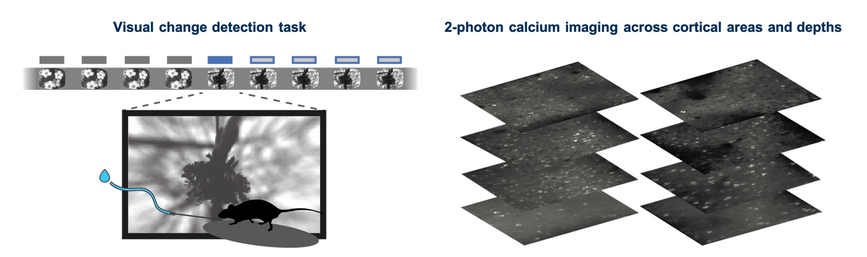

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

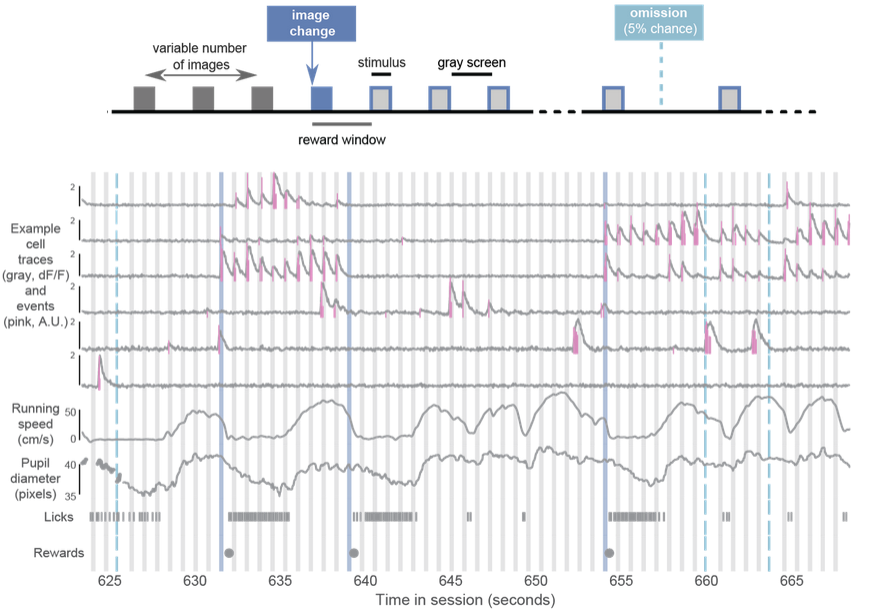

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [265]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy import optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

jupyter_black.load()
from typing import Tuple

from joblib import Parallel, delayed
from tqdm import tqdm
import time
import oopsi

from oasis.functions import (
    gen_data,
    gen_sinusoidal_data,
    deconvolve,
    estimate_parameters,
)
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2

In [2]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["frequency", "direction", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data(
    path="/Users/sascha/Library/Mobile Documents/com~apple~CloudDocs/Uni_Tübingen/Semester2/NeuralDataScience/Assignments/FinalProject/data/project-01"
)  # adjust the path as necessary

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure in the preferred orientation/direction/frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of:
1. Pre-processing
2. Spike inference
3. Tuning function fitting
4. Statistical testing.

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

# Implementation

We are following these steps to answer the questions:

We filter the data to have smoother signals by cutting out low frequencies to be able to detect spikes in high-frequency components.
We then calculate the threshold for spikes and detect positions of spikes in the filtered data.
Because we are interested in the specificity of neurons to stimuls characteristics we look at each trial of stimulus presentation and segment the reactions of neurons in each stimulus segment.
Since only certain trials show detect spikes we filter out trials for each neurons in which spikes occur to continue the analysis with these.
We then correct each stimulus reaction to the baseline activity of the neuron before the stimulus presentation.
We then fit tuning curves to the detected spikes after stimulus presentation and by permutation analysis check which neurons have certain orientation, direction and frequency preference.
Then using the mask we plot the entire filed of neurons with their respective preference to first check if we can visually see an organization of the neurons into columns.
We statistically analyze this by ...



# 1 Pre-processing

## 1.1 Data Exploration

We start by looking at what the the raw data looks like for one example neuron:

In [242]:
running_speed = data["running_speed"][1]
running_speed

array([   9.67741,    9.71067,    9.74392, ..., 3849.55347, 3849.58673,
       3849.61999], shape=(115471,))

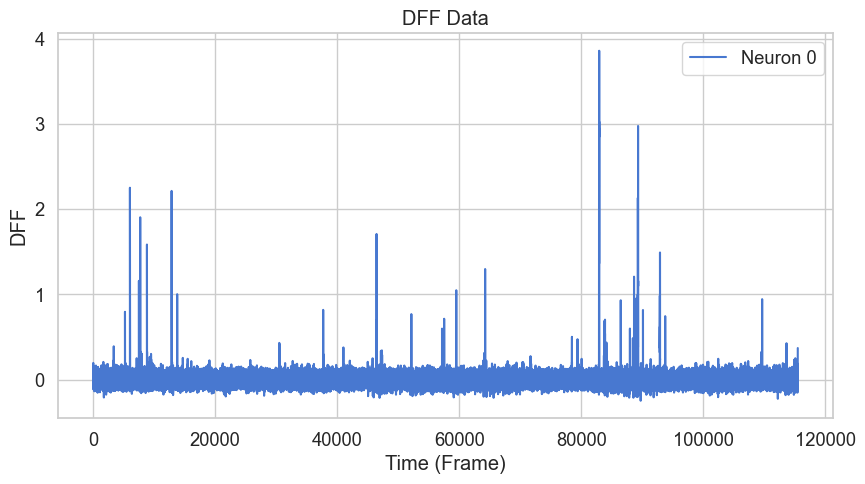

In [ ]:
# plot dff
sns.set(style="whitegrid", palette="muted", font_scale=1.2)


# Plot the dff data for a given neuron
neuron = 0  # Specify the neuron index to plot
dff = data["dff"]

plt.figure(figsize=(10, 5))
plt.plot(
    dff[neuron],
    label=f"Neuron {neuron}",
)
plt.title("df/F Data")
plt.xlabel("Time (Frame)")
plt.ylabel("df/F")
plt.legend()
plt.show()

Let's look at the first drifting grating stimulus epoch for the first neuron in the dataset. We will plot the dF/F data for this neuron over time.

Text(0, 0.5, 'DFF')

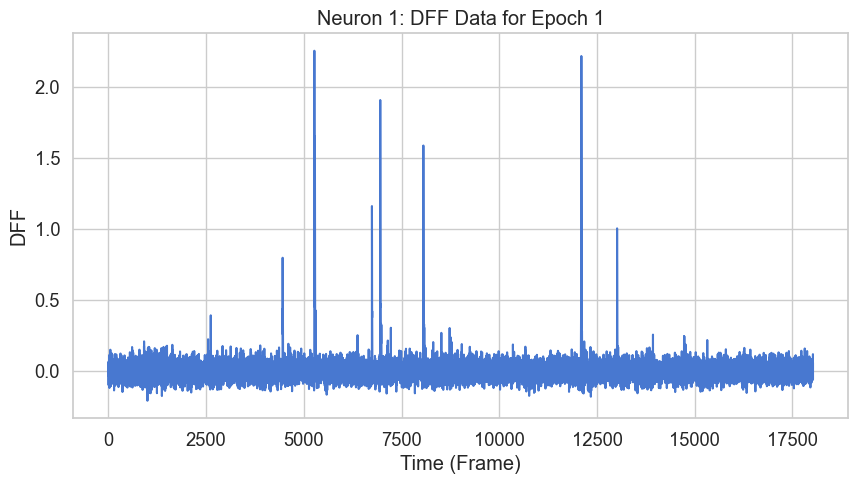

In [ ]:
# Epoch 1: drifting grating stimulus [747, 18775]

start, end = data["stim_epoch_table"].iloc[0][["start", "end"]]
neuron = 0  # Specify the neuron index to plot
plt.figure(figsize=(10, 5))
plt.plot(
    dff[neuron][start:end],
    label=f"Neuron {neuron} - Epoch 1",
)
plt.title("Neuron 1: DFF Data for Epoch 1")
plt.xlabel("Time (Frame)")
plt.ylabel("df/F")

To see more of the frequency structure let´s look at a spcific segment of the data:

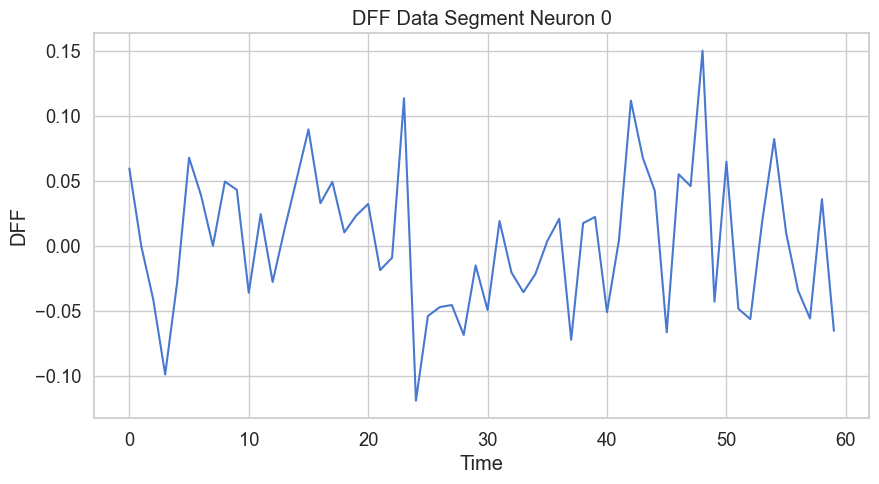

In [ ]:
# look at specific trial / segment of the data for the example neuron
plt.figure(figsize=(10, 5))

# extract stimulus trial for the example neuron
stim_trial = data["stim_table"].iloc[0]  # First stimulus trial
start, end = int(stim_trial["start"]), int(stim_trial["end"])

plt.plot(
    data["dff"][0][start:end],
    label="Neuron 0",
)
plt.title("df/F Data Segment Neuron 0")
plt.xlabel("Time")
plt.ylabel("df/F")
plt.show()

When inspecting multiple neurons, we also see a lot of variance across them. Hence, the data is not normalized and to be able to better detect artefacts like spikes we need to highpass filter, smooth and normalize the data.

## 1.2 Data Segmentation

There are stimulus epochs with a drifting grating stimulus which we have to extract from the data. We can use the `stim_epoch_table` to segment the data into these epochs. Additionally, we can use the `stim_table` to get the parameters of the stimulus (e.g. frequency, direction, etc.) and the trials of the epochs.

In [9]:
stim_table = data["stim_table"]
stim_table

frequency  direction  blank_sweep     start       end
0          1.0      225.0          0.0     747.0     807.0
1          2.0      180.0          0.0     837.0     897.0
2          4.0       90.0          0.0     927.0     987.0
3          1.0      270.0          0.0    1018.0    1077.0
4          4.0      135.0          0.0    1108.0    1168.0
..         ...        ...          ...       ...       ...
623        4.0      315.0          0.0  114794.0  114854.0
624        2.0       45.0          0.0  114884.0  114944.0
625        4.0      180.0          0.0  114975.0  115034.0
626        4.0      270.0          0.0  115065.0  115125.0
627        1.0      180.0          0.0  115155.0  115215.0

[628 rows x 5 columns]

In [10]:
stim_epoch_table = data["stim_epoch_table"]
stim_epoch_table

stimulus  start     end
0    drifting_gratings    747   18775
1  natural_movie_three  19709   37767
2    natural_movie_one  38671   47699
3    drifting_gratings  48602   66630
4          spontaneous  66780   75697
5  natural_movie_three  75698   93756
6    drifting_gratings  94659  115215

In [19]:
dff = data["dff"]
trials = data["stim_table"]
stim_epoch = data["stim_epoch_table"]

# convert start and end columns to integers
stim_epoch["start"] = stim_epoch["start"].astype(int)
stim_epoch["end"] = stim_epoch["end"].astype(int)
trials["start"] = trials["start"].astype(int)
trials["end"] = trials["end"].astype(int)

df = pd.DataFrame(dff.T)

# name row index "neuron"
df.columns.name = "neuron"
# name columns "frame"
df.index.name = "frame"
df

neuron       0         1         2         3         4         5         6    \
frame                                                                          
0       0.080074  0.302720  0.168157  0.159289  0.221676  0.159628  0.173332   
1       0.073333  0.192155  0.243857  0.121167  0.174817  0.013748  0.109984   
2       0.106239  0.248387  0.112327  0.051255  0.167537  0.066555  0.163519   
3       0.046158  0.215546  0.251947  0.127826  0.142919  0.138798  0.147587   
4       0.085196  0.242169  0.136350  0.226716  0.126805  0.082720  0.144326   
...          ...       ...       ...       ...       ...       ...       ...   
115466  0.154725  0.124501  0.077588  0.133862  0.129848  0.077844  0.120590   
115467  0.160838  0.087792  0.192173  0.109220  0.171813  0.132161  0.159852   
115468  0.129136  0.230828  0.111689  0.044588  0.184538  0.090515  0.105022   
115469  0.117740  0.099345  0.290004  0.129835  0.133267  0.139781  0.234262   
115470  0.371383  0.346914  0.238241  0.304729  0.156809  0.100721  0.253355   

neuron       7         8         9    ...       96        97        98   \
frame                                 ...                                 
0       0.113588  0.091763  0.147363  ...  0.192031  0.185569  0.183121   
1       0.198653  0.096743  0.240087  ...  0.253337  0.181051  0.175788   
2       0.034570  0.002772  0.100160  ...  0.123753  0.098486  0.154131   
3       0.144340  0.077789  0.161366  ...  0.156185  0.089490  0.154265   
4       0.133917  0.085611  0.105228  ...  0.122848  0.054876  0.099048   
...          ...       ...       ...  ...       ...       ...       ...   
115466  0.082888  0.711875  0.091389  ...  0.231280  0.174985  0.078371   
115467  0.059533  0.815080  0.151121  ...  0.332294  0.216960  0.008951   
115468  0.061299  0.690214  0.162594  ...  0.348038  0.127954  0.051149   
115469  0.122270  0.548292  0.167373  ...  0.345922  0.078545  0.072667   
115470  0.153773  0.426073  0.122743  ...  0.689181  0.130299  0.233400   

neuron       99        100       101       102       103       104       105  
frame                                                                         
0       0.149597  0.174043  0.210124  0.109017  0.198182  0.239257  0.143669  
1       0.168539  0.116540  0.189274  0.124441  0.159228  0.110361  0.084411  
2       0.164914  0.080800  0.108441  0.157915  0.217271  0.161507  0.038156  
3       0.156744  0.159786  0.101578  0.157973  0.070341  0.043087  0.003984  
4       0.092528  0.103015  0.115101  0.166471  0.069938  0.120642  0.025158  
...          ...       ...       ...       ...       ...       ...       ...  
115466  0.017643  0.075789  0.119994  0.085362  0.178834  0.195636  0.209696  
115467  0.040502  0.093579  0.082193  0.116991  0.253364  0.122037  0.082179  
115468  0.006436  0.102642  0.041770  0.110850  0.200873  0.138055  0.092020  
115469  0.062905  0.092922  0.186020  0.042368  0.337976  0.197287  0.197644  
115470  0.195698  0.028882  0.188787  0.195134  0.499658  0.232815  0.235863  

[115471 rows x 106 columns]

In [20]:
# get only drifting gratings epochs
drifting_grating_epochs = stim_epoch[
    stim_epoch["stimulus"] == "drifting_gratings"
].reset_index(drop=True)
drifting_grating_epochs

stimulus  start     end
0  drifting_gratings    747   18775
1  drifting_gratings  48602   66630
2  drifting_gratings  94659  115215

In [21]:
# cut out drifting grating epochs
records = []
for i, row in drifting_grating_epochs.iterrows():
    # get all neurons in this epoch
    epoch_df = df.loc[row.start : row.end, :]
    # add epoch number as column index
    epoch_df.index = pd.MultiIndex.from_product(
        [[i], epoch_df.index], names=["epoch", "frame"]
    )
    # add to records
    records.append(epoch_df)
# create dataframe from records
df_raw = pd.concat(records, axis=0)
df_raw

neuron             0         1         2         3         4         5    \
epoch frame                                                                
0     747     0.059512 -0.063161 -0.019814 -0.064979  0.067324  0.021476   
      748    -0.000203 -0.049975  0.030449  0.041945  0.006195 -0.014444   
      749    -0.041120 -0.068027  0.055002 -0.067749 -0.005289 -0.046250   
      750    -0.098806  0.074266 -0.006529  0.006800  0.031468  0.046876   
      751    -0.028460  0.028866  0.051883  0.115626  0.001330  0.075100   
...                ...       ...       ...       ...       ...       ...   
2     115211 -0.012725  0.011566  0.043530  0.018481 -0.075041  0.010294   
      115212 -0.012888  0.003882  0.037825 -0.063592 -0.007616  0.039843   
      115213  0.044822 -0.022734 -0.016276 -0.086995 -0.020194  0.031156   
      115214 -0.055499 -0.053176 -0.048795 -0.084779 -0.009320  0.068994   
      115215 -0.109390 -0.006519 -0.077936 -0.056792 -0.002331 -0.035282   

neuron             6         7         8         9    ...       96        97   \
epoch frame                                           ...                       
0     747    -0.025787 -0.000141 -0.006664  0.036956  ... -0.043115 -0.005537   
      748    -0.008338  0.031437  0.049524 -0.037182  ...  0.033092  0.003726   
      749    -0.029259  0.101742 -0.025278 -0.051245  ...  0.004700  0.035787   
      750     0.001280  0.008053  0.017523 -0.021524  ...  0.134587 -0.001434   
      751     0.028452 -0.049464  0.017742  0.041560  ...  0.048615  0.008920   
...                ...       ...       ...       ...  ...       ...       ...   
2     115211  0.042833  0.066424  0.898020 -0.021838  ...  0.024481  0.041598   
      115212 -0.028717 -0.042497  1.191723 -0.051500  ... -0.069082  0.071589   
      115213 -0.014092  0.032496  1.026063  0.034322  ...  0.012087  0.132241   
      115214 -0.072743 -0.098667  0.824707  0.031996  ... -0.022002  0.036148   
      115215 -0.036401 -0.003220  0.890062  0.022936  ... -0.037532  0.062050   

neuron             98        99        100       101       102       103  \
epoch frame                                                                
0     747    -0.001483  0.153535 -0.008959  0.014240  0.085813 -0.066683   
      748     0.068913  0.086297 -0.010431 -0.006715  0.055087 -0.052482   
      749    -0.012316  0.001702  0.012815  0.050914  0.083215  0.037526   
      750     0.026124 -0.091168 -0.010381  0.124242 -0.003417  0.056991   
      751     0.071050  0.019964  0.102945  0.093136  0.005253  0.023856   
...                ...       ...       ...       ...       ...       ...   
2     115211  0.021203  0.112598  0.065437 -0.012071 -0.021133 -0.037243   
      115212 -0.035257  0.040120  0.061543 -0.072416 -0.005645  0.014365   
      115213 -0.005524  0.031642 -0.005066  0.048101 -0.041793 -0.017129   
      115214 -0.013789 -0.022765 -0.005168 -0.026585  0.003097 -0.021029   
      115215  0.051854  0.094462 -0.049081  0.000000 -0.024927  0.000970   

neuron             104       105  
epoch frame                       
0     747     0.046780  0.036651  
      748     0.187832  0.028809  
      749     0.100032  0.009712  
      750     0.168290  0.026584  
      751     0.035082  0.137172  
...                ...       ...  
2     115211 -0.053058 -0.018237  
      115212 -0.014696 -0.000033  
      115213  0.006574 -0.077658  
      115214 -0.017389  0.000000  
      115215 -0.068638 -0.009105  

[56615 rows x 106 columns]

After having created a dataframe with the segmented data and having filtered out the blank sweeps we can start the actual preprocessing of the timeseries data. We have seen that there are a lot of high frequency components in the data which we want to filter out to be able to detect spikes in the data. We can use a butter bandpass filter to cut out high frequencies and filtfilt function to apply the filter to the data without introducing phase shifts.

In [ ]:
# estimate the sampling frequency
dt = np.mean(np.diff(data["t"]))
print("dt:", dt)
fs = np.round(1 / dt)
print("fs:", fs)
cut_off = 0.5  # cutoff frequency for the filter
print("cut_off:", cut_off)

dt: 0.03325489373863341
fs: 30.0
cut_off: 0.5


## 1.3 Filtering, Normalization and Smoothing

The smoothing has been adapted from Yaksi and Friedrich (2006) and the normalization and filtering is based on the methods of Vogelstein et al. (2020). The steps are as follows:
1. **Filtering**: We apply a bandpass filter to the data to remove high frequency noise. This helps in isolating the relevant frequency components of the calcium signals.
2. **Normalization**: The filtered signals are then normalized to have a consistent baseline, which is crucial for comparing activity across different neurons and epochs.
3. **Smoothing**: Finally, we apply a smoothing algorithm to reduce any remaining noise and artifacts, ensuring that the extracted signals more accurately reflect the underlying neural activity.

In [ ]:
def highpass_filter(group, fs=30, cutoff=0.5):
    """
    Apply highpass filter to each trace in the group.

    Parameters:
    - group: DataFrame with trace
    - fs: sampling frequency (Hz)
    - cutoff: cutoff frequency (Hz)

    Returns: DataFrame with filtered traces
    """
    nyq = 0.5 * fs
    # normalize the cutoff frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(4, normal_cutoff, btype="low", analog=False)
    filtered = filtfilt(b, a, group.values)
    return pd.Series(filtered, index=group.index.get_level_values("frame"))


def normalize_trace(group):
    """Normalize the trace to the range [0, 1].

    Parameters:
    - group: DataFrame with trace
    """

    f_min = group.values.min()
    f_max = group.values.max()
    return pd.Series(
        (group.values - f_min) / (f_max - f_min),
        index=group.index.get_level_values("frame"),
    )


def smooth_trace(group, thr_noise=1.0, max_iter=5000):
    """
    smooth the trace using iterative local averaging based on peak amplitude differences

    parameters:
    - group: series with calcium trace (df/f values)
    - thr_noise: noise threshold for peak amplitude differences
    - max_iter: maximum number of smoothing iterations

    returns:
    - smoothed trace as a pandas series with same index as input
    """
    trace = group.values.copy()
    smoothed = trace.copy()
    iteration = 0

    while iteration < max_iter:
        peaks, _ = find_peaks(smoothed)
        if len(peaks) < 2:
            break

        amp_diffs = np.diff(smoothed[peaks])
        amp_diffs = np.insert(amp_diffs, 0, np.inf)
        pmin_idx = np.argmin(np.abs(amp_diffs))

        if abs(amp_diffs[pmin_idx]) >= thr_noise:
            break

        if pmin_idx == 0 or pmin_idx == len(peaks) - 1:
            break

        start = peaks[pmin_idx - 1]
        end = peaks[pmin_idx + 1]

        segment = smoothed[start : end + 1].copy()
        for _ in range(3):
            segment[1:-1] = (segment[:-2] + segment[1:-1] + segment[2:]) / 3

        smoothed[start : end + 1] = segment
        iteration += 1

    return pd.Series(smoothed, index=group.index.get_level_values("frame"))

In [102]:
df_filtered = (
    df_raw.stack("neuron")
    .groupby(["neuron", "epoch"])
    .apply(highpass_filter, fs=30, cutoff=0.5)
    .groupby(["neuron", "epoch"])
    .apply(normalize_trace)
    .unstack("neuron")
)
df_filtered

neuron             0         1         2         3         4         5    \
epoch frame                                                                
0     747     0.205041  0.000000  0.201189  0.000000  0.233279  0.136643   
      748     0.203099  0.013988  0.207664  0.083451  0.226652  0.136581   
      749     0.201018  0.029092  0.214076  0.164982  0.219969  0.136485   
      750     0.198810  0.045323  0.220386  0.244210  0.213259  0.136357   
      751     0.196490  0.062691  0.226558  0.320767  0.206552  0.136196   
...                ...       ...       ...       ...       ...       ...   
2     115211  0.105004  0.751521  0.211653  0.191105  0.249700  0.416030   
      115212  0.102587  0.753420  0.210046  0.188176  0.249458  0.414285   
      115213  0.100458  0.754911  0.208609  0.185596  0.249243  0.412750   
      115214  0.098608  0.756056  0.207341  0.183355  0.249056  0.411419   
      115215  0.097025  0.756914  0.206241  0.181439  0.248895  0.410285   

neuron             6         7         8         9    ...       96        97   \
epoch frame                                           ...                       
0     747     0.018682  0.322033  0.082538  0.200014  ...  0.233229  0.118694   
      748     0.047830  0.323275  0.082832  0.192659  ...  0.234341  0.120671   
      749     0.076337  0.324388  0.083138  0.185596  ...  0.235668  0.122686   
      750     0.104067  0.325378  0.083456  0.178846  ...  0.237190  0.124733   
      751     0.130897  0.326253  0.083781  0.172430  ...  0.238891  0.126809   
...                ...       ...       ...       ...  ...       ...       ...   
2     115211  0.181564  0.311854  0.623758  0.296327  ...  0.119356  0.271637   
      115212  0.179029  0.310743  0.628029  0.296992  ...  0.119191  0.272657   
      115213  0.176845  0.309815  0.631623  0.297558  ...  0.119042  0.273516   
      115214  0.174989  0.309051  0.634601  0.298033  ...  0.118910  0.274228   
      115215  0.173436  0.308434  0.637030  0.298425  ...  0.118795  0.274809   

neuron             98        99        100       101       102       103  \
epoch frame                                                                
0     747     0.130797  0.738727  0.153955  0.308356  0.593111  0.000000   
      748     0.135532  0.698372  0.156253  0.310692  0.573582  0.045764   
      749     0.140065  0.658536  0.158496  0.312839  0.554248  0.090861   
      750     0.144377  0.619374  0.160670  0.314761  0.535201  0.135096   
      751     0.148452  0.581034  0.162761  0.316420  0.516527  0.178283   
...                ...       ...       ...       ...       ...       ...   
2     115211  0.184942  0.423950  0.057382  0.228786  0.116550  0.445820   
      115212  0.185161  0.426335  0.057227  0.228633  0.116441  0.446283   
      115213  0.185360  0.428406  0.057083  0.228490  0.116342  0.446679   
      115214  0.185540  0.430179  0.056951  0.228359  0.116253  0.447013   
      115215  0.185698  0.431674  0.056833  0.228242  0.116174  0.447291   

neuron             104       105  
epoch frame                       
0     747     0.192719  0.599603  
      748     0.192648  0.607922  
      749     0.192511  0.616153  
      750     0.192308  0.624205  
      751     0.192039  0.631981  
...                ...       ...  
2     115211  0.112896  0.249596  
      115212  0.112401  0.249396  
      115213  0.111980  0.249241  
      115214  0.111625  0.249123  
      115215  0.111330  0.249036  

[56615 rows x 106 columns]

In [100]:
df_preprocessed = (
    df_raw.stack("neuron")
    .groupby(["neuron", "epoch"])
    .apply(highpass_filter, fs=30, cutoff=0.5)
    .groupby(["neuron", "epoch"])
    .apply(normalize_trace)
    .groupby(["neuron", "epoch"])
    .apply(smooth_trace)
    .unstack("neuron")
)
df_preprocessed.reset_index(inplace=False)
df_preprocessed

neuron             0         1         2         3         4         5    \
epoch frame                                                                
0     747     0.205041  0.000000  0.201189  0.000000  0.233279  0.136643   
      748     0.203099  0.013988  0.207664  0.083451  0.226652  0.136581   
      749     0.201018  0.029092  0.214076  0.164982  0.219969  0.136485   
      750     0.198810  0.045323  0.220386  0.244210  0.213259  0.136357   
      751     0.196490  0.062691  0.226558  0.320767  0.206552  0.136196   
...                ...       ...       ...       ...       ...       ...   
2     115211  0.105004  0.751521  0.211653  0.191105  0.249700  0.416030   
      115212  0.102587  0.753420  0.210046  0.188176  0.249458  0.414285   
      115213  0.100458  0.754911  0.208609  0.185596  0.249243  0.412750   
      115214  0.098608  0.756056  0.207341  0.183355  0.249056  0.411419   
      115215  0.097025  0.756914  0.206241  0.181439  0.248895  0.410285   

neuron             6         7         8         9    ...       96        97   \
epoch frame                                           ...                       
0     747     0.018682  0.322033  0.082538  0.200014  ...  0.233229  0.118694   
      748     0.047830  0.323275  0.082832  0.192659  ...  0.234341  0.120671   
      749     0.076337  0.324388  0.083138  0.185596  ...  0.235668  0.122686   
      750     0.104067  0.325378  0.083456  0.178846  ...  0.237190  0.124733   
      751     0.130897  0.326253  0.083781  0.172430  ...  0.238891  0.126809   
...                ...       ...       ...       ...  ...       ...       ...   
2     115211  0.181564  0.311854  0.623758  0.296327  ...  0.119356  0.271637   
      115212  0.179029  0.310743  0.628029  0.296992  ...  0.119191  0.272657   
      115213  0.176845  0.309815  0.631623  0.297558  ...  0.119042  0.273516   
      115214  0.174989  0.309051  0.634601  0.298033  ...  0.118910  0.274228   
      115215  0.173436  0.308434  0.637030  0.298425  ...  0.118795  0.274809   

neuron             98        99        100       101       102       103  \
epoch frame                                                                
0     747     0.130797  0.738727  0.153955  0.308356  0.593111  0.000000   
      748     0.135532  0.698372  0.156253  0.310692  0.573582  0.045764   
      749     0.140065  0.658536  0.158496  0.312839  0.554248  0.090861   
      750     0.144377  0.619374  0.160670  0.314761  0.535201  0.135096   
      751     0.148452  0.581034  0.162761  0.316420  0.516527  0.178283   
...                ...       ...       ...       ...       ...       ...   
2     115211  0.184942  0.423950  0.057382  0.228786  0.116550  0.445820   
      115212  0.185161  0.426335  0.057227  0.228633  0.116441  0.446283   
      115213  0.185360  0.428406  0.057083  0.228490  0.116342  0.446679   
      115214  0.185540  0.430179  0.056951  0.228359  0.116253  0.447013   
      115215  0.185698  0.431674  0.056833  0.228242  0.116174  0.447291   

neuron             104       105  
epoch frame                       
0     747     0.192719  0.599603  
      748     0.192648  0.607922  
      749     0.192511  0.616153  
      750     0.192308  0.624205  
      751     0.192039  0.631981  
...                ...       ...  
2     115211  0.112896  0.249596  
      115212  0.112401  0.249396  
      115213  0.111980  0.249241  
      115214  0.111625  0.249123  
      115215  0.111330  0.249036  

[56615 rows x 106 columns]

The filtering process has smoothed the signal, reducing noise while preserving the essential features of the neural activity. This will help in further analyses such as identifying peaks, calculating statistics, or visualizing the data more clearly.

Text(0.5, 0.98, 'Inspect preprocessed raw data')

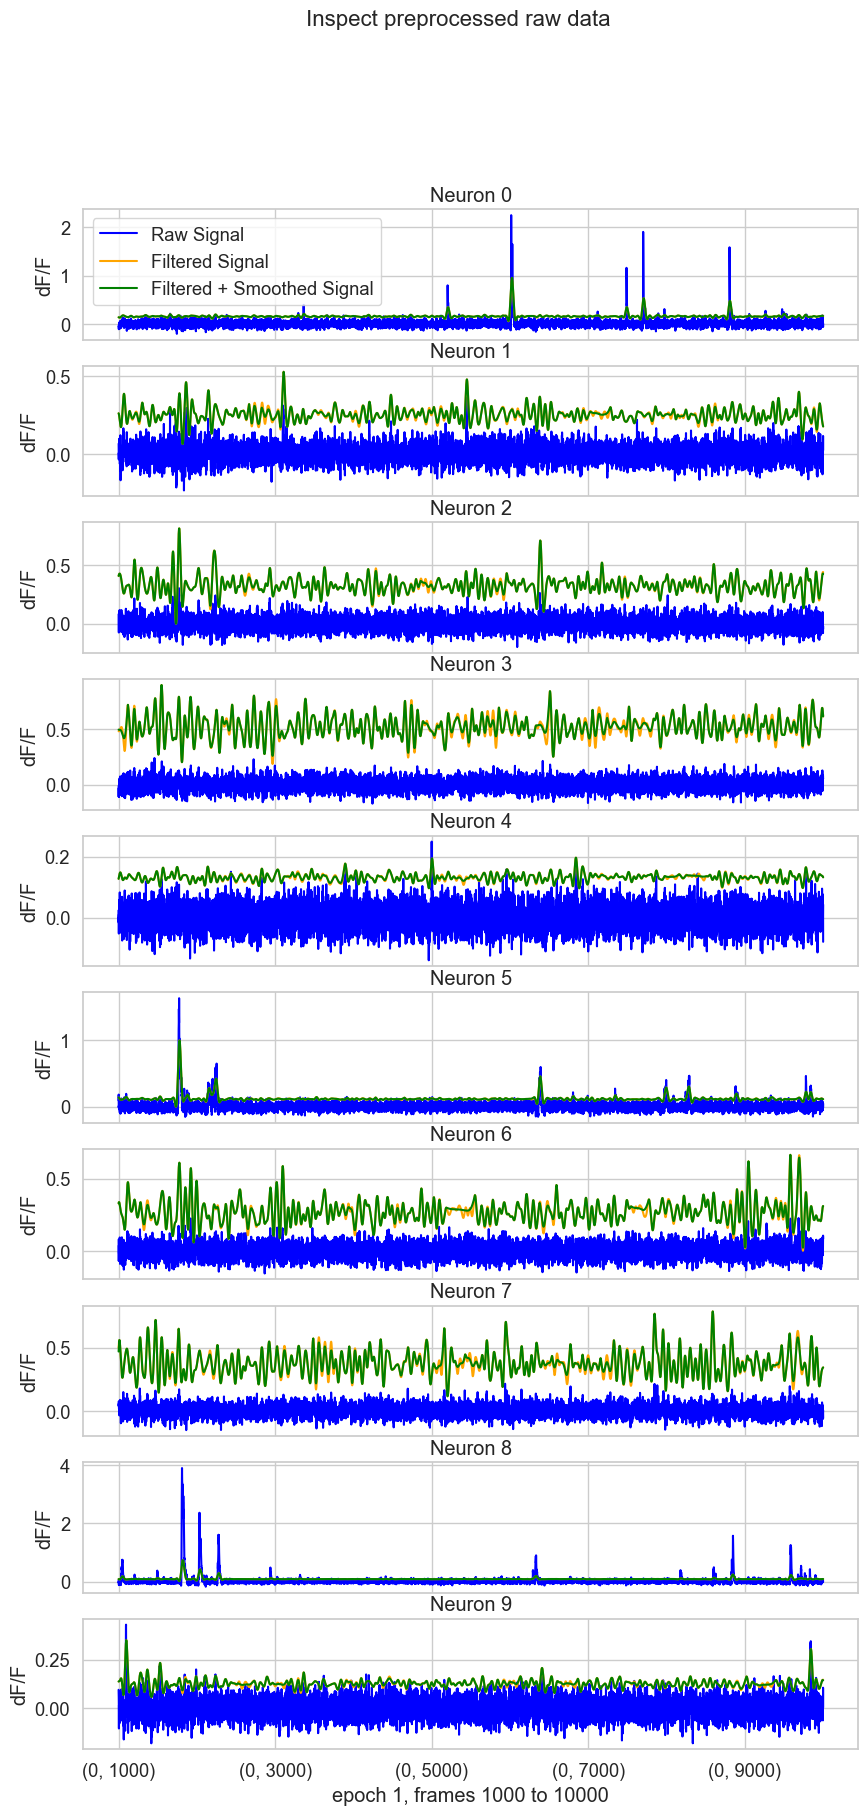

In [115]:
# plot raw and filtered signal epoch 1 of neuron 1, 15 and 30
neuron_indices = range(0, 10)  # Neuron indices to plot
fig, axes = plt.subplots(len(neuron_indices), 1, figsize=(10, 20), sharex=True)

for i, neuron in enumerate(neuron_indices):
    ax = axes[i]
    df_raw.loc[(0, slice(1000, 10000)), neuron].plot(
        ax=ax, label="Raw Signal", color="blue"
    )
    df_filtered.loc[(0, slice(1000, 10000)), neuron].plot(
        ax=ax, label="Filtered Signal", color="orange"
    )

    df_preprocessed.loc[(0, slice(1000, 10000)), neuron].plot(
        ax=ax, label="Filtered + Smoothed Signal", color="green"
    )
    ax.set_title(f"Neuron {neuron}")
    ax.set_ylabel("dF/F")
    ax.set_xlabel("epoch 1, frames 1000 to 10000")
    if i == 0:
        ax.legend()

# set title for the entire figure
fig.suptitle("Inspect preprocessed raw data", fontsize=16)

## 1.4 Spike Inference

We can now continue with the analysis using the filtered data. First, we detect the spikes in the entire dataset for each neuron.

In [196]:
from oasis.functions import (
    gen_data,
    gen_sinusoidal_data,
    deconvolve,
    estimate_parameters,
)
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2

Best parameters for each neuron:
{0: (np.float64(0.1), np.float64(0.1)), 1: (np.float64(0.1), np.float64(0.4)), 2: (np.float64(0.1), np.float64(0.30000000000000004)), 3: (np.float64(0.1), np.float64(0.5)), 4: (np.float64(0.1), np.float64(0.1)), 5: (np.float64(0.1), np.float64(0.1)), 6: (np.float64(0.1), np.float64(0.1)), 7: (np.float64(0.1), np.float64(0.6)), 8: (np.float64(0.1), np.float64(0.1)), 9: (np.float64(0.1), np.float64(0.1)), 10: (np.float64(0.1), np.float64(0.1)), 11: (np.float64(0.1), np.float64(0.1)), 12: (np.float64(0.1), np.float64(0.1)), 13: (np.float64(0.1), np.float64(0.6)), 14: (np.float64(0.1), np.float64(0.4)), 15: (np.float64(0.1), np.float64(0.1)), 16: (np.float64(0.1), np.float64(0.5)), 17: (np.float64(0.1), np.float64(0.1)), 18: (np.float64(0.1), np.float64(0.1)), 19: (np.float64(0.1), np.float64(0.1)), 20: (np.float64(0.1), np.float64(0.1)), 21: (np.float64(0.1), np.float64(0.1)), 22: (np.float64(0.1), np.float64(0.1)), 23: (np.float64(0.1), np.float64(0.1)), 

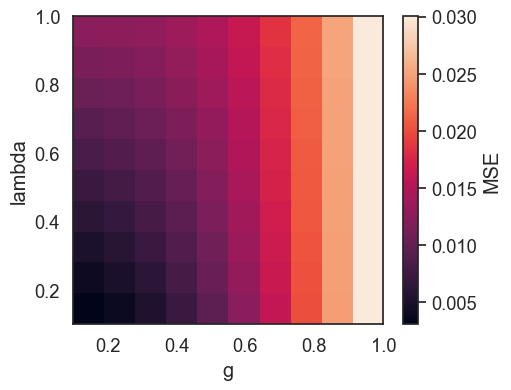

In [ ]:
determine_parameters = True

# parameter search space
lam_values = np.linspace(0.1, 1.0, 10)
g_values = np.linspace(0.1, 1.0, 10)

if determine_parameters:
    # evaluate the performance of deconvolution for different parameter combinations
    def evaluate_performance(true_signal, inferred_signal):
        mse = np.mean((true_signal - inferred_signal) ** 2)
        return mse

    # grid search
    best_params = {}
    best_performance = {}
    performance_grid = np.zeros((len(lam_values), len(g_values)))

    for neuron in df_raw.columns:
        best_mse = float("inf")
        best_lam = None
        best_g = None

        for lam_i, lam in enumerate(lam_values):
            for gi, g in enumerate(g_values):
                try:
                    # convert trace to float64 for oasisAR1 compatibility
                    trace = df_raw[neuron].values.astype(np.float64)
                    inferred_signal = oasisAR1(trace, g, lam)[1]
                    mse = evaluate_performance(trace, inferred_signal)
                    performance_grid[lam_i, gi] += mse
                except Exception as e:
                    print(f"An error occurred: {e}")
                    continue

                if mse < best_mse:
                    best_mse = mse
                    best_lam = lam
                    best_g = g

        if best_lam is not None and best_g is not None:
            best_params[neuron] = (best_lam, best_g)
            best_performance[neuron] = best_mse
        else:
            print(f"Skipping neuron {neuron} due to invalid parameters.")

    print("Best parameters for each neuron:")
    print(best_params)
    # ensure best_params and best_performance are not empty before calculating averages
    if best_params and best_performance:
        print("Best parameters averaged over all neurons:")
        print(np.mean(list(best_params.values()), axis=0))
        print("Best performance averaged over all neurons:")
        print(np.mean(list(best_performance.values())))
    else:
        print("No valid parameters found for any neuron.")
    print("Best parameters averaged over all neurons:")
    print(np.mean(list(best_params.values()), axis=0))
    print("Best performance averaged over all neurons:")
    print(np.mean(list(best_performance.values())))

    # average the performance across all neurons
    performance_grid /= len(df_raw.columns)

    # save performance grid as .npy file
    np.save("performance_grid.npy", performance_grid)

else:
    # load performance grid
    performance_grid = np.load("performance_grid.npy")

# plot performance grid
plt.figure(figsize=(5, 4))
plt.imshow(
    performance_grid,
    origin="lower",
    aspect="auto",
    extent=[g_values[0], g_values[-1], lam_values[0], lam_values[-1]],
)
plt.colorbar(label="MSE")
plt.xlabel("g")
plt.ylabel("lambda")
plt.show()

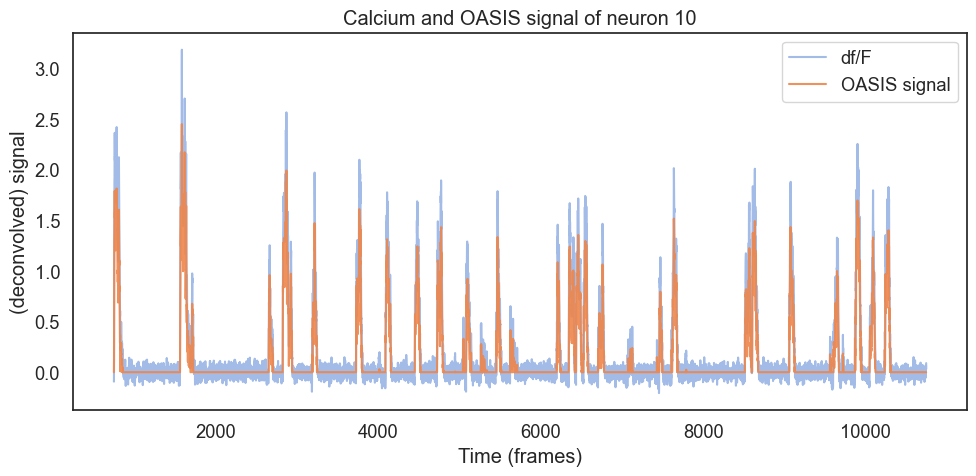

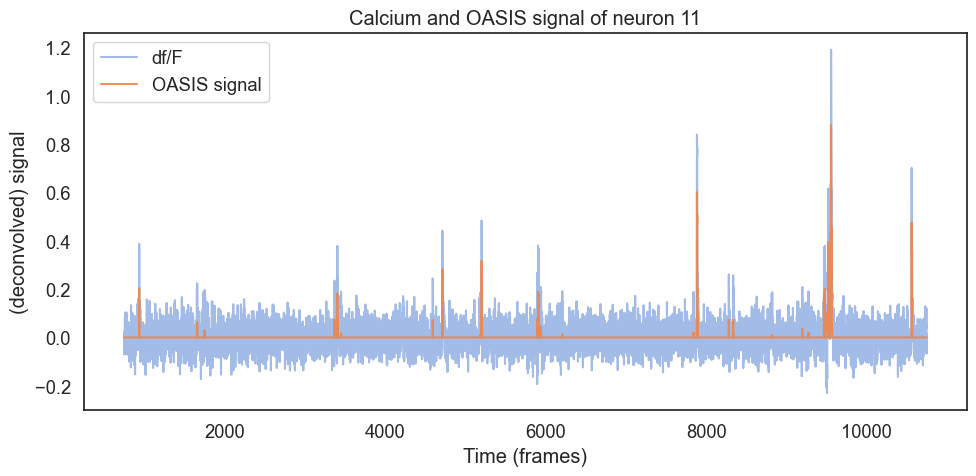

In [263]:
sns.set(style="white", palette="muted", font_scale=1.2)

determine_parameters = False  # set to True if you want to run the grid search
# set best parameters from grid search (or manually)
if determine_parameters:
    best_g = np.mean(list(best_params.values()), axis=0)[1]
    best_lam = np.mean(list(best_params.values()), axis=0)[0]
else:
    best_g = 0.2
    best_lam = 0.2

sampling_rate = 1 / fs  # fs must be defined earlier

# run deconvolution using oasisAR1
ds_oasis = []
for neuron in df_raw.columns:
    # cast to float64 for Cython compatibility
    y = df_raw[neuron].values.astype(np.float64)
    c, s = oasisAR1(y, g=best_g, lam=best_lam)
    ds_oasis.append(c)

plot_lim = 10000  # number of frames to show

for i, neuron in enumerate(df_raw.columns[10:12]):
    plt.figure(figsize=(10, 5))

    # plot raw trace
    plt.plot(
        df_raw.index.get_level_values("frame")[:plot_lim],
        df_raw[neuron].values[:plot_lim],
        alpha=0.5,
        label="df/F",
    )

    # plot deconvolved trace
    plt.plot(
        df_raw.index.get_level_values("frame")[:plot_lim],
        df_oasis[neuron][:plot_lim],
        alpha=0.9,
        label="OASIS signal",
    )

    plt.title(f"Calcium and OASIS signal of neuron {neuron}")
    plt.xlabel("Time (frames)")
    plt.ylabel("(deconvolved) signal")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [271]:
def apply_oasis(group):
    """
    Apply the OASIS algorithm to the group of traces.

    Parameters:
    - group: DataFrame with raw traces

    Returns: Series with deconvolved traces
    """
    trace = group.values.copy().astype(
        np.float64
    )  # ensure trace is float64 for Cython compatibility
    c, s = oasisAR1(trace, g=best_g, lam=best_lam)
    return pd.Series(s, index=group.index.get_level_values("frame"))


def apply_oopsi(group, dt=1 / 30):
    """
    apply oopsi deconvolution to a trace group and return results as pd.Series

    parameters:
    - group: pd.Series (dF/F values for one neuron × epoch)
    - dt: time step in seconds

    returns:
    - pd.Series with spike train (n) indexed by frame
    """
    trace = group.values.astype(np.float64)
    n, _ = oopsi.fast(trace, dt=dt, iter_max=100, update=True)
    return pd.Series(n, index=group.index)


df_oasis = (
    df_raw.stack("neuron")
    .groupby(["neuron", "epoch"])
    .apply(apply_oasis)
    .unstack("neuron")
)
df_oasis

neuron        0    1    2    3    4    5    6    7         8    9    ...  96   \
epoch frame                                                          ...        
0     747     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...  0.0   
      748     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...  0.0   
      749     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...  0.0   
      750     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...  0.0   
      751     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...  0.0   
...           ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...  ...   
2     115211  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.552046  0.0  ...  0.0   
      115212  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.884119  0.0  ...  0.0   
      115213  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.659718  0.0  ...  0.0   
      115214  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.491494  0.0  ...  0.0   
      115215  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.557120  0.0  ...  0.0   

neuron        97   98   99   100  101  102  103       104  105  
epoch frame                                                     
0     747     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
      748     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.014455  0.0  
      749     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
      750     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
      751     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
...           ...  ...  ...  ...  ...  ...  ...       ...  ...  
2     115211  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
      115212  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
      115213  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
      115214  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
      115215  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  

[56615 rows x 106 columns]

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
import time


def apply_oopsi_parallel(df, dt=1 / 30, n_jobs=4):
    """
    parallel apply of oopsi deconvolution across neuron × epoch groups

    parameters:
    - df: multi-index dataframe (epoch, frame) × neuron
    - dt: time step (default 1/30 for 30 Hz)
    - n_jobs: number of parallel jobs

    returns:
    - dataframe with spike estimates (same shape as df)
    """
    # stack to long format: index = (epoch, frame), columns = neuron → becomes Series
    df_stacked = df.stack("neuron")

    # group by neuron and epoch
    grouped = df_stacked.groupby(["neuron", "epoch"])

    print("running oopsi in parallel per (neuron, epoch)...")
    start = time.time()

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(apply_oopsi)(group, dt)
        for _, group in tqdm(grouped, total=len(grouped))
    )

    print(f"done in {time.time() - start:.2f} seconds.")

    # combine results and reshape
    df_oopsi = pd.concat(
        results, keys=grouped.groups.keys(), names=["neuron", "epoch", "frame"]
    )
    df_oopsi = df_oopsi.unstack("neuron")

    return df_oopsi


df_oopsi = apply_oopsi_parallel(df_preprocessed, dt=1 / 30, n_jobs=4)

running oopsi in parallel per (neuron, epoch)...


100%|██████████| 318/318 [32:41<00:00,  6.17s/it]


done in 2031.62 seconds.


ValueError: Length of names must match number of levels in MultiIndex.

In [288]:
df_oopsi = pd.read_pickle("df_oopsi.pkl")

In [289]:
df_oopsi

neuron                 0         1             2             3    \
epoch frame                                                        
0     747     5.469718e-08  1.000000  1.851868e-03  1.000000e+00   
      748     5.469718e-08  1.000000  1.851868e-03  1.000000e+00   
      749     4.218048e-11  0.000187  7.462197e-07  4.865372e-03   
      750     2.807474e-11  0.000033  6.892935e-07  1.742041e-02   
      751     8.792513e-11  0.000179  6.085242e-07  9.427236e-03   
...                    ...       ...           ...           ...   
2     115211  1.692482e-12  0.000211  2.172336e-05  1.077017e-11   
      115212  7.531390e-12  0.000018  2.596665e-05  4.836499e-11   
      115213  2.795869e-11  0.000127  9.810662e-05  6.756478e-11   
      115214  3.024338e-11  0.000240  1.195169e-04  6.196634e-11   
      115215  4.396643e-12  0.000074  1.816521e-05  3.119172e-11   

neuron                 4             5             6         7    \
epoch frame                                                        
0     747     6.996289e-08  5.122817e-08  7.856578e-07  1.000000   
      748     6.996289e-08  5.122817e-08  7.856578e-07  1.000000   
      749     2.607021e-11  1.508937e-11  1.897230e-10  0.000122   
      750     1.063640e-11  2.527631e-11  3.538414e-10  0.000106   
      751     1.762213e-11  1.890525e-11  2.188249e-10  0.000299   
...                    ...           ...           ...       ...   
2     115211  1.401512e-10  9.243197e-11  8.018805e-11  0.000073   
      115212  3.391591e-10  6.380023e-11  8.782799e-12  0.000165   
      115213  4.878999e-10  1.239860e-10  7.042919e-11  0.000176   
      115214  7.865495e-10  1.353429e-10  1.787300e-11  0.000106   
      115215  2.082465e-09  1.187855e-10  1.121674e-10  0.000109   

neuron                 8             9    ...           96            97   \
epoch frame                               ...                               
0     747     7.134956e-08  9.213741e-08  ...  6.955749e-08  6.748540e-08   
      748     7.134956e-08  9.213741e-08  ...  6.955749e-08  6.748540e-08   
      749     3.784480e-10  3.501427e-10  ...  6.803002e-10  8.125733e-10   
      750     1.897257e-09  3.349404e-10  ...  2.577509e-10  4.450162e-10   
      751     9.553398e-10  3.358890e-03  ...  1.180787e-10  6.054926e-10   
...                    ...           ...  ...           ...           ...   
2     115211  1.365473e-11  2.828049e-11  ...  9.805747e-11  2.460383e-11   
      115212  1.732211e-11  4.927054e-12  ...  1.171376e-10  3.161549e-11   
      115213  1.943404e-11  3.739308e-12  ...  2.023778e-10  3.725852e-11   
      115214  2.930905e-11  2.885443e-11  ...  2.016190e-10  3.662133e-11   
      115215  7.352669e-11  2.941631e-11  ...  2.745844e-10  1.921002e-10   

neuron                 98            99            100           101  \
epoch frame                                                            
0     747     6.443264e-08  4.891471e-07  7.676278e-08  1.447984e-07   
      748     6.443264e-08  4.891471e-07  7.676278e-08  1.447984e-07   
      749     8.809350e-10  6.044386e-11  4.201229e-02  3.238069e-11   
      750     1.579785e-09  5.342873e-11  7.812345e-10  3.143211e-11   
      751     1.125367e-09  1.782615e-11  4.735540e-02  3.395084e-12   
...                    ...           ...           ...           ...   
2     115211  2.620796e-10  1.283556e-05  3.676896e-01  5.353146e-10   
      115212  3.158222e-10  5.117647e-05  7.344088e-10  3.312264e-10   
      115213  2.584883e-10  2.125301e-04  5.422092e-10  1.844666e-01   
      115214  1.101522e-10  2.067514e-04  2.938678e-10  6.084896e-10   
      115215  9.351274e-03  1.137542e-04  4.155449e-10  5.793626e-09   

neuron                 102           103           104           105  
epoch frame                                                           
0     747     1.161741e-06  1.000000e+00  8.166416e-08  1.873024e-07  
      748     1.161741e-06  1.000000e+00  8.166416e-08  1.873024e-07  
      7

Text(0.5, 0.98, 'Inspect preprocessed raw data')

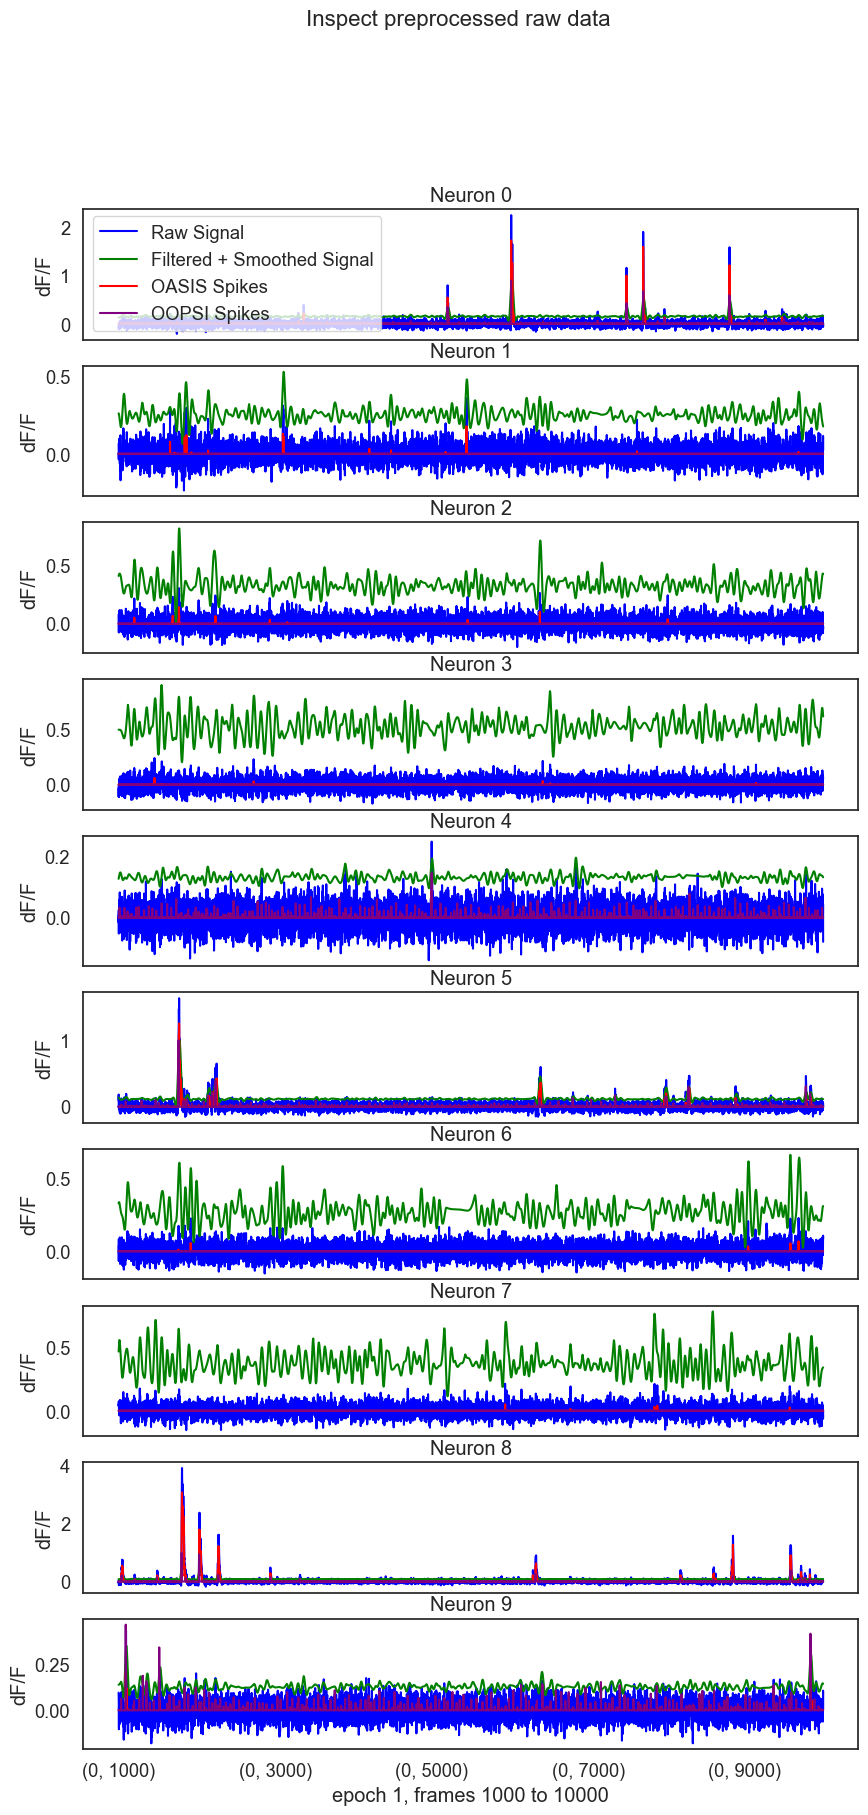

In [290]:
# plot raw and filtered signal epoch 1 of neuron 1, 15 and 30
neuron_indices = range(0, 10)  # Neuron indices to plot
fig, axes = plt.subplots(len(neuron_indices), 1, figsize=(10, 20), sharex=True)

interval = slice(1000, 10000)  # frames to plot

for i, neuron in enumerate(neuron_indices):
    ax = axes[i]
    df_raw.loc[(0, interval), neuron].plot(ax=ax, label="Raw Signal", color="blue")

    df_preprocessed.loc[(0, interval), neuron].plot(
        ax=ax, label="Filtered + Smoothed Signal", color="green"
    )
    df_oasis.loc[(0, interval), neuron].plot(ax=ax, label="OASIS Spikes", color="red")
    df_oopsi.loc[(0, interval), neuron].plot(
        ax=ax, label="OOPSI Spikes", color="purple"
    )
    ax.set_title(f"Neuron {neuron}")
    ax.set_ylabel("dF/F")
    ax.set_xlabel(f"epoch 1, frames {interval.start} to {interval.stop}")
    if i == 0:
        # outside plot
        ax.legend()

# set title for the entire figure
fig.suptitle("Inspect preprocessed raw data", fontsize=16)

Text(0.5, 0.98, 'Inspect preprocessed raw data')

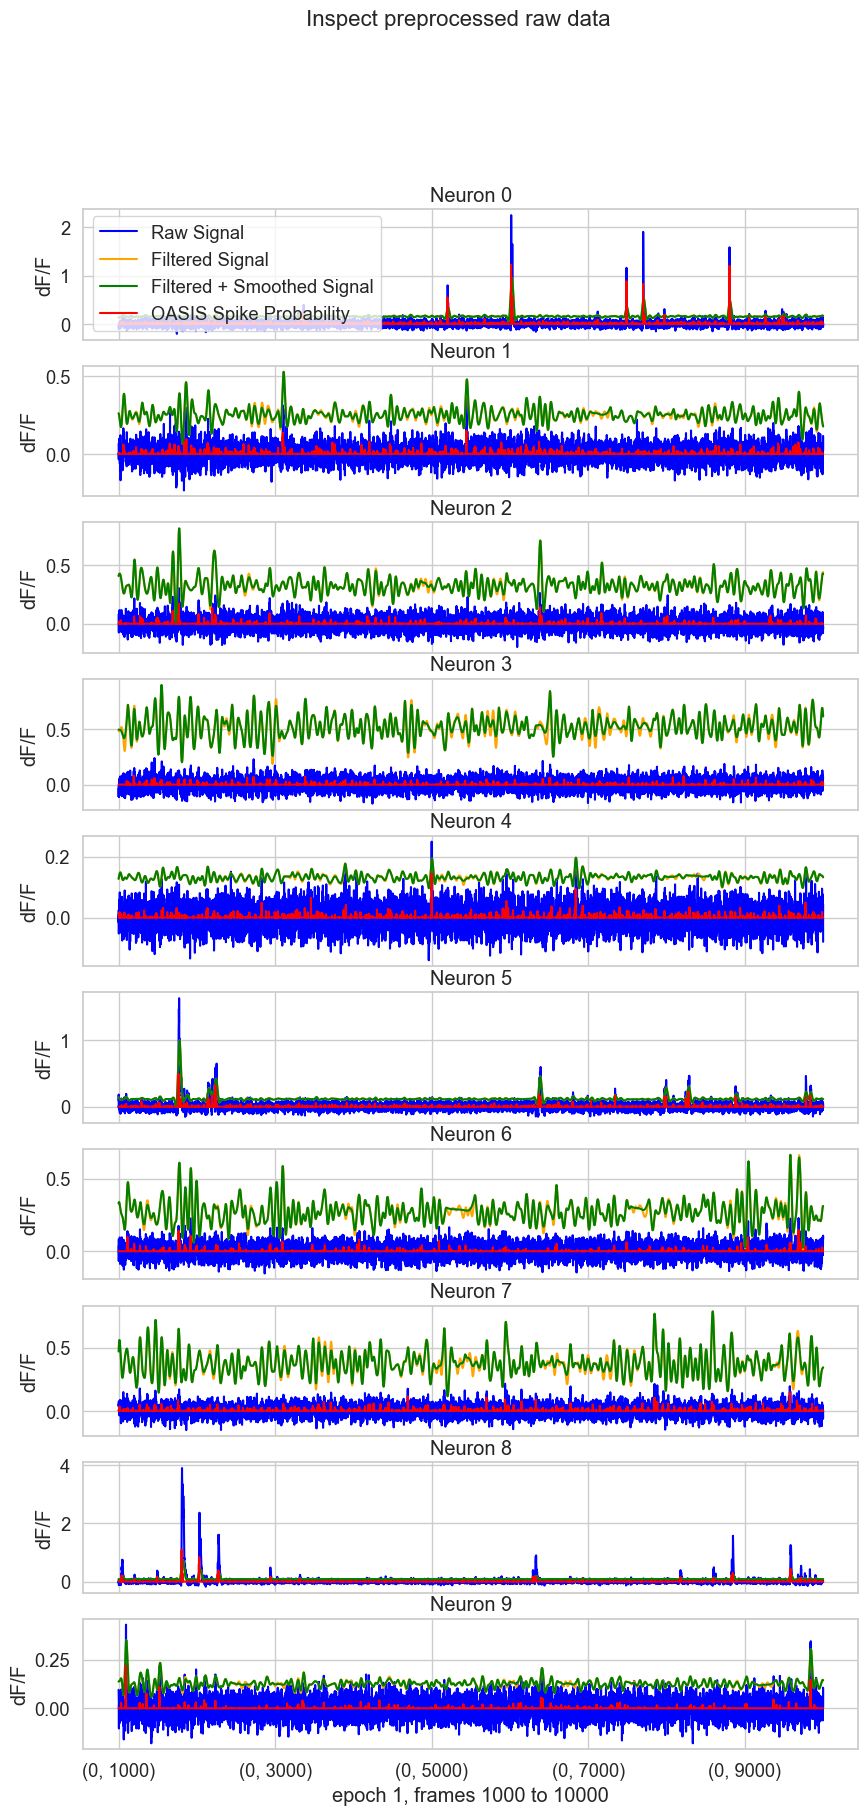

In [ ]:
# plot raw and filtered signal epoch 1 of neuron 1, 15 and 30
neuron_indices = range(0, 10)  # Neuron indices to plot
fig, axes = plt.subplots(len(neuron_indices), 1, figsize=(10, 20), sharex=True)

interval = slice(1000, 10000)  # frames to plot

for i, neuron in enumerate(neuron_indices):
    ax = axes[i]
    df_raw.loc[(0, interval), neuron].plot(
        ax=ax, label="Raw Signal", color="blue"
    )

    df_preprocessed.loc[(0, interval), neuron].plot(
        ax=ax, label="Filtered + Smoothed Signal", color="green"
    )
    df_oasis.loc[(0, interval), neuron].plot(
        ax=ax, label="OASIS Spikes", color="red"
    )
    df_oopsi.loc[(0, interval), neuron].plot(
        ax=ax, label="OOPSI Spikes", color="purple"
    )
    ax.set_title(f"Neuron {neuron}")
    ax.set_ylabel("dF/F")
    ax.set_xlabel(f"epoch 1, frames {interval.start} to {interval.stop}")
    if i == 0:
        # outside plot
        ax.legend()

# set title for the entire figure
fig.suptitle("Inspect preprocessed raw data", fontsize=16)

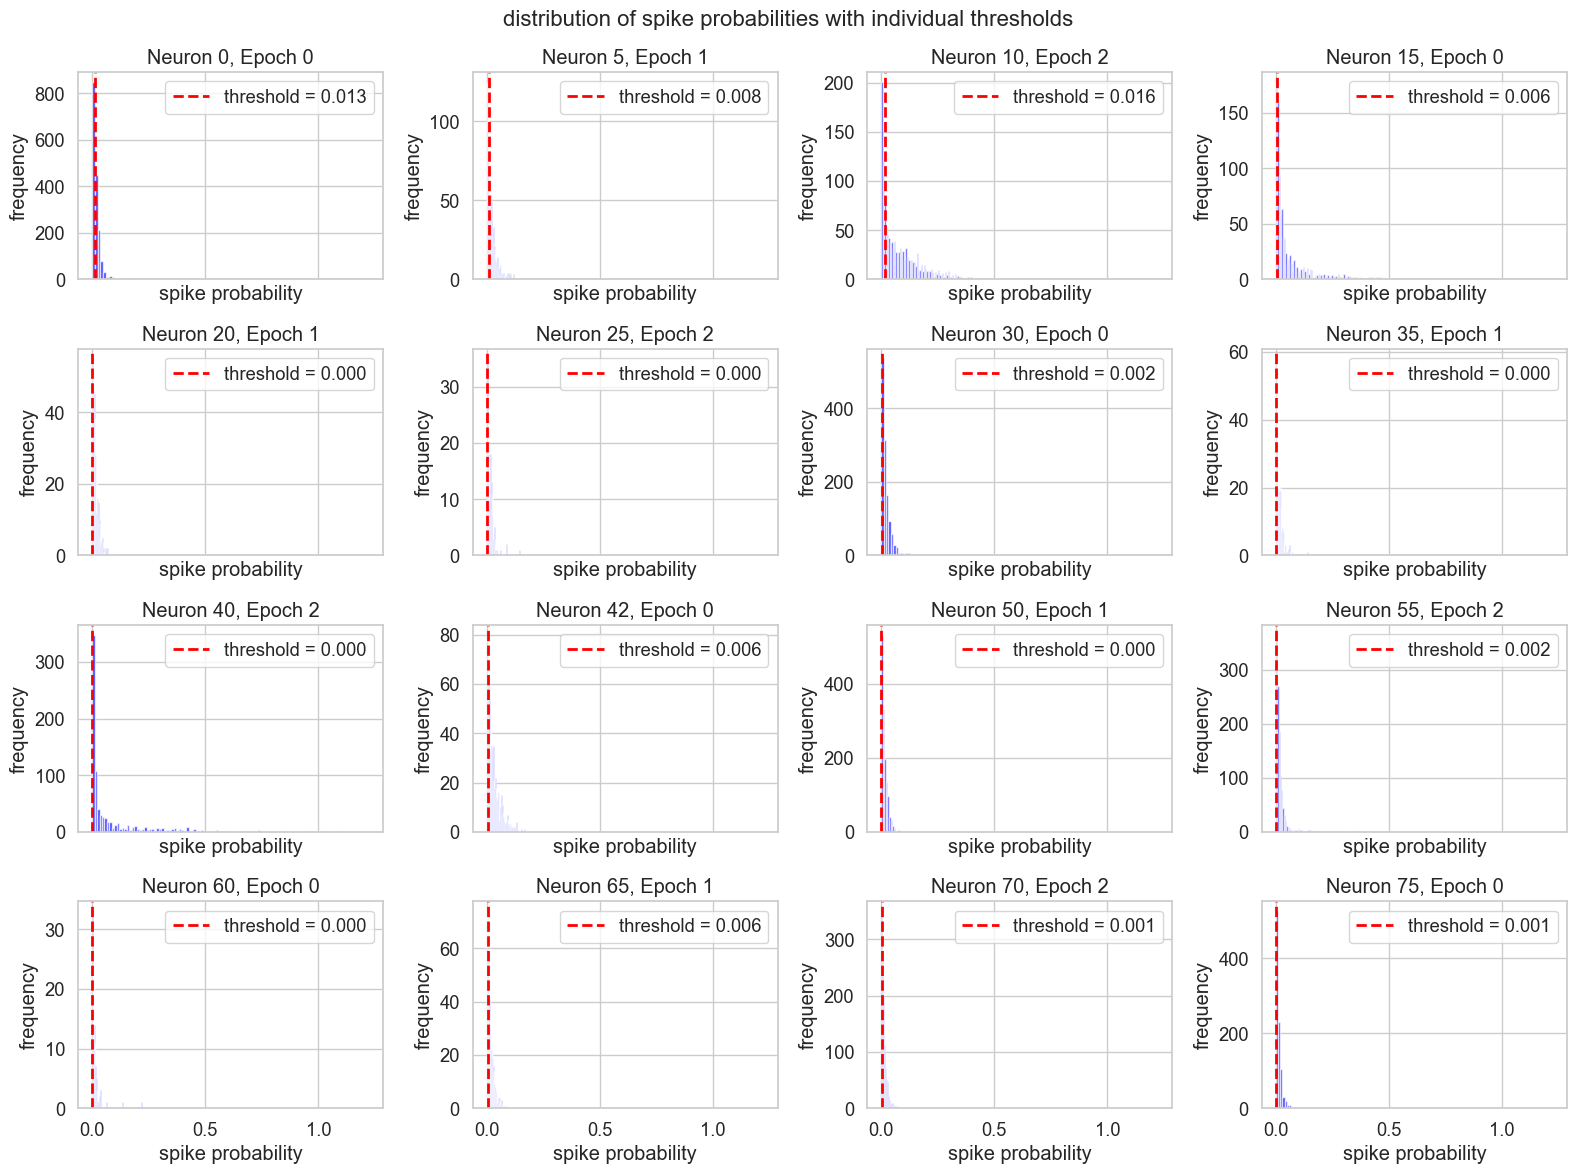

In [188]:
# select 16 neuron indices and corresponding epochs
neuron_indices = [0, 5, 10, 15, 20, 25, 30, 35, 40, 42, 50, 55, 60, 65, 70, 75]
epoch_indices = [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0]

# exclude values below 1e-5 to avoid plotting very small spike probabilities
df_spikeprob_oasis = df_spikeprob_oasis[df_spikeprob_oasis > 1e-4].fillna(0)

# compute individual thresholds (95th percentile) for each neuron

neuron_thresholds = pd.Series(
    {
        neuron: np.percentile(df_spikeprob_oasis[neuron].values, 95)
        for neuron in df_spikeprob_oasis.columns
    }
)

# plot histograms with threshold overlay
fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for i, (neuron, epoch) in enumerate(zip(neuron_indices, epoch_indices)):
    ax = axes[i]
    probs = df_spikeprob_oasis.loc[(epoch, slice(None)), neuron]
    nonzero_probs = probs[probs > 1e-5]

    if len(nonzero_probs) > 0:
        nonzero_probs.hist(bins=100, ax=ax, color="blue", alpha=0.7)
        threshold = neuron_thresholds[neuron]
        ax.axvline(
            threshold,
            color="red",
            linestyle="--",
            linewidth=2,
            label=f"threshold = {threshold:.3f}",
        )
        ax.set_title(f"Neuron {neuron}, Epoch {epoch}")
        ax.set_xlabel("spike probability")
        ax.set_ylabel("frequency")
        ax.legend()
    else:
        ax.set_title(f"Neuron {neuron}, Epoch {epoch}\n(no spikes)")
        ax.axis("off")

fig.suptitle(
    "distribution of spike probabilities with individual thresholds", fontsize=16
)
fig.tight_layout()

In [186]:
# replace the oasis values by binary values based on the threshold
df_oasis_binary = df_spikeprob_oasis.copy()
for neuron in df_spikeprob_oasis.columns:
    threshold = neuron_thresholds[neuron]
    df_oasis_binary[neuron] = (df_spikeprob_oasis[neuron] > threshold).astype(int)
df_oasis_binary

neuron        0    1    2    3    4    5    6    7    8    9    ...  96   97   \
epoch frame                                                     ...             
0     747       0    0    0    0    0    0    0    0    0    0  ...    0    0   
      748       0    0    1    0    0    0    0    1    1    0  ...    1    1   
      749       0    0    0    0    0    0    0    0    0    0  ...    0    1   
      750       0    0    0    0    0    1    0    0    1    0  ...    1    0   
      751       0    0    1    1    0    0    0    0    0    1  ...    0    0   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2     115211    0    0    0    1    0    0    1    0    0    1  ...    0    0   
      115212    0    0    0    0    0    1    0    0    0    1  ...    0    0   
      115213    0    0    0    0    0    0    1    0    0    0  ...    0    0   
      115214    0    0    0    0    1    0    1    0    0    1  ...    0    0   
      115215    0    0    0    1    0    0    0    0    0    1  ...    0    0   

neuron        98   99   100  101  102  103  104  105  
epoch frame                                           
0     747       0    0    0    0    0    0    0    0  
      748       1    0    0    0    0    0    1    0  
      749       0    0    1    1    0    1    0    0  
      750       0    0    0    1    0    1    0    0  
      751       0    0    1    0    0    0    0    1  
...           ...  ...  ...  ...  ...  ...  ...  ...  
2     115211    0    0    1    1    0    0    0    0  
      115212    1    0    0    1    0    0    0    0  
      115213    0    0    0    0    0    0    0    0  
      115214    0    0    1    1    0    0    0    0  
      115215    0    0    0    1    0    0    0    0  

[56615 rows x 106 columns]

In [ ]:


# OOPSI parameters
# 1#
# butter order = 5
# fs = 30
# cut_off = 6
# --> n_spikes = 19290
# 2#
# butter order = 2
# fs = 30
# cut_off = 3
# iter_max = 5
# --> n_spikes = 4737107
# 3#


def run_oopsi_single(trace, dt):
    n, C = oopsi.fast(trace, dt=dt, iter_max=100, update=True)
    return n, C


# --- Progress-bar-friendly Parallel wrapper ---
def run_oopsi_all_traces(traces, dt, n_jobs=4):
    print("Running OOPSI in parallel with progress bar...")
    start = time.time()
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(run_oopsi_single)(trace, dt)
        for trace in tqdm(traces, desc="Processing neurons", unit="neuron")
    )
    print(f" Done in {time.time() - start:.2f} seconds.")
    return results

# --- Run it ---
results = run_oopsi_all_traces(filtered_dff, dt=dt, n_jobs=4)
# --- Unpack results ---
n_traces = np.array([r[0] for r in results])
C_traces = np.array([r[1] for r in results])

Running OOPSI in parallel with progress bar...


Processing neurons: 100%|██████████| 106/106 [23:30<00:00, 13.31s/neuron]


 Done in 1535.03 seconds.


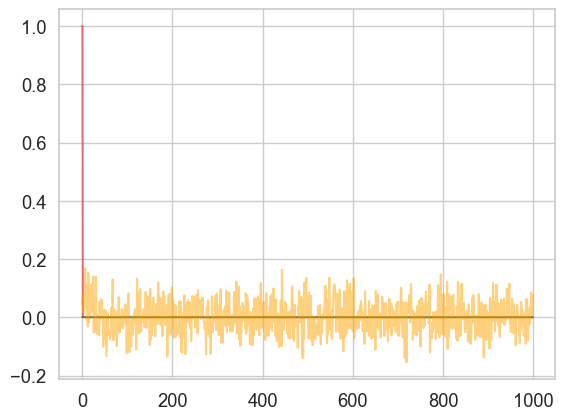

In [22]:
n_trace, C_trace = oopsi.fast(filtered_dff[0][0:1000], dt=dt, iter_max=100, update=True)
# n

plt.plot(n_trace, label="OOPSI DFF", color="red", alpha=0.5)
plt.plot(C_trace, label="OOPSI C", color="green", alpha=0.5)
plt.plot(filtered_dff[0][0:1000], label="Filtered DFF", color="orange", alpha=0.5)

In [38]:
list_input = np.array(
    filtered_dff_df[filtered_dff_df["Neuron"] == 1]["FilteredDFF"].values
)
list_input

array([ 0.05975808,  0.02123568, -0.00706481, ..., -0.01863571,
       -0.02648942, -0.03009344], shape=(36295,))

In [39]:
n, C = run_oopsi_single(list_input, dt=dt)

In [41]:
# how many spikes were detected?
print(f"Number of spikes detected: {np.sum(n >= 0.5)}")

Number of spikes detected: 36288


In [84]:
oopsi_spikes = np.load("oopsi_results_3.npz", allow_pickle=True)[
    "spikes"
]  # Load the spikes from the saved file
# print total number of spikes detected
oopsi_bool = oopsi_spikes >= 0.75  # Convert to boolean array
print(f"Total number of spikes detected by OOPSI: {oopsi_bool.sum()}")

Total number of spikes detected by OOPSI: 430486


In [ ]:
# add oopsi spikes to the filtered_dff_df
filtered_dff_df.drop(columns=["OOPSI_Spikes"], inplace=True)
filtered_dff_df["OOPSI_Spikes"] = 0
for neuron_id in filtered_dff_df["Neuron"].unique():
    neuron_mask = filtered_dff_df["Neuron"] == neuron_id
    filtered_dff_df.loc[neuron_mask, "OOPSI_Spikes"] = oopsi_spikes[neuron_id - 1]



/var/folders/_w/fvv3yfg57mj4b3g4yftq72cr0000gn/T/ipykernel_868/3562673903.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.395601667927194e-07 8.395601667927194e-07 0.7577022916725048 ...
 8.757536415050498e-11 2.654385006222134e-10 1.937740668750836e-10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_dff_df.loc[neuron_mask, "OOPSI_Spikes"] = oopsi_spikes[neuron_id - 1]


Neuron  Trial  Epoch  FrameIdx  Frequency  BlankSweep    Dir  \
6405        106      1      1       747        1.0         0.0  225.0   
6406        106      1      1       748        1.0         0.0  225.0   
6407        106      1      1       749        1.0         0.0  225.0   
6408        106      1      1       750        1.0         0.0  225.0   
6409        106      1      1       751        1.0         0.0  225.0   
...         ...    ...    ...       ...        ...         ...    ...   
4040397     106    628      3    115211        1.0         0.0  180.0   
4040398     106    628      3    115212        1.0         0.0  180.0   
4040399     106    628      3    115213        1.0         0.0  180.0   
4040400     106    628      3    115214        1.0         0.0  180.0   
4040401     106    628      3    115215        1.0         0.0  180.0   

         relTime  FilteredDFF  Spike OOPSI_Spikes  
6405           0     0.010378      0          0.0  
6406           1     0.026256      0          0.0  
6407           2     0.043413      0     0.158824  
6408           3     0.060231      0     0.158918  
6409           4     0.072464      0     0.036442  
...          ...          ...    ...          ...  
4040397       56    -0.008863      0          0.0  
4040398       57    -0.012682      0          0.0  
4040399       58    -0.014908      0          0.0  
4040400       59    -0.013319      0          0.0  
4040401       60    -0.008842      0          0.0  

[36295 rows x 11 columns]

In [85]:
# make all values in the OOPSI_Spikes column
filtered_dff_df["OOPSI_Spikes"] = filtered_dff_df["OOPSI_Spikes"] >= 0.75

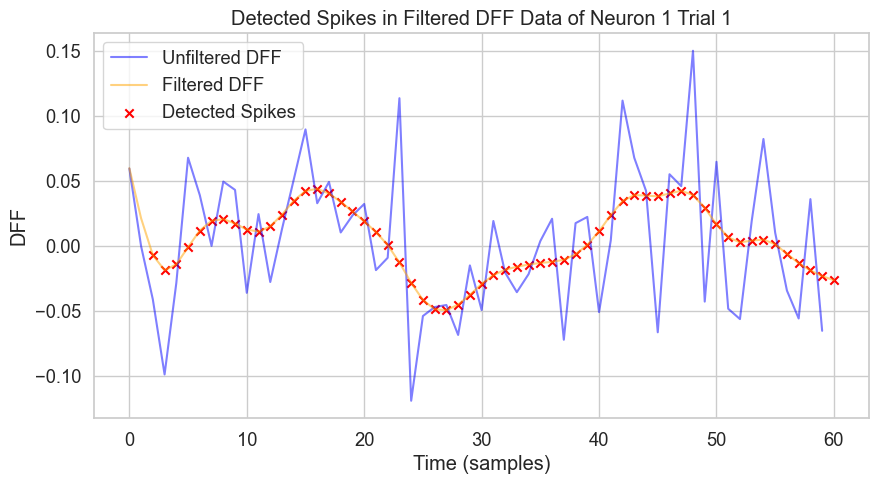

In [88]:
# get start and end of the first trial
start, end = stim_table.iloc[0][["start", "end"]].astype(int)

# filter the dataframe for neuron 1 and trial 1
neuron1_trial1 = filtered_dff_df[
    (filtered_dff_df["Neuron"] == 1) & (filtered_dff_df["Trial"] == 1)
]

neuron1_trial1["FilteredDFF"][start:end]
# plot trial 1 for neuron 1
plt.figure(figsize=(10, 5))
plt.plot(data["dff"][0][start:end], label="Unfiltered DFF", color="blue", alpha=0.5)
plt.plot(
    neuron1_trial1["FilteredDFF"],
    label="Filtered DFF",
    color="orange",
    alpha=0.5,
)
# add spikes
plt.scatter(
    neuron1_trial1.index[
        neuron1_trial1["OOPSI_Spikes"] == 1
    ],  # get the indices of the spikes
    neuron1_trial1["FilteredDFF"][neuron1_trial1["OOPSI_Spikes"] == 1],
    # get the filtered DFF values at the spike indices
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title("Detected Spikes in Filtered DFF Data of Neuron 1 Trial 1")
plt.xlabel("Time (samples)")
plt.ylabel("DFF")
plt.legend()
plt.show()

## Segment data by stimulus presentation and epochs

Since we want to analyze each neuron´s preference for direction and frequency we need to look at the signal directly after a stimulus presentation. Therefore, we split the data into segements for each trial.

In [29]:
stims = data["stim_table"]
# convert start and end times to integers
stims["start"] = stims["start"].astype(int)
stims["end"] = stims["end"].astype(int)
stims

frequency  direction  blank_sweep   start     end
0          1.0      225.0          0.0     747     807
1          2.0      180.0          0.0     837     897
2          4.0       90.0          0.0     927     987
3          1.0      270.0          0.0    1018    1077
4          4.0      135.0          0.0    1108    1168
..         ...        ...          ...     ...     ...
623        4.0      315.0          0.0  114794  114854
624        2.0       45.0          0.0  114884  114944
625        4.0      180.0          0.0  114975  115034
626        4.0      270.0          0.0  115065  115125
627        1.0      180.0          0.0  115155  115215

[628 rows x 5 columns]

In [30]:
# remove the blank sweeps
stims = stims[stims["blank_sweep"] == 0]
stims

frequency  direction  blank_sweep   start     end
0          1.0      225.0          0.0     747     807
1          2.0      180.0          0.0     837     897
2          4.0       90.0          0.0     927     987
3          1.0      270.0          0.0    1018    1077
4          4.0      135.0          0.0    1108    1168
..         ...        ...          ...     ...     ...
623        4.0      315.0          0.0  114794  114854
624        2.0       45.0          0.0  114884  114944
625        4.0      180.0          0.0  114975  115034
626        4.0      270.0          0.0  115065  115125
627        1.0      180.0          0.0  115155  115215

[598 rows x 5 columns]

In [31]:
def build_spike_dataframe(dff, spikes_all, stims):
    """
    builds a dataframe containing spike information matched to stimulation trials.
    for each spike, includes neuron index, trial index, frame index, frequency, direction, relative time, and dff value.

    inputs:
    - dff: array of shape (neurons, frames), containing dff signal values
    - spikes_all: list of arrays, each containing spike frame indices for each neuron
    - stims: dataframe containing columns 'start', 'end', 'frequency', and 'direction'

    output:
    - spike_df: dataframe with spike and stimulation information
    """

    # create an intervalindex from start and end
    intervals = pd.IntervalIndex.from_arrays(
        stims["start"], stims["end"], closed="both"
    )

    # flatten all spike times
    spikes_all_flat = np.concatenate(spikes_all)

    # find for each spike time which trial (if any) it belongs to
    spike_trial_idx = intervals.get_indexer(spikes_all_flat)

    # convert spike_times_all into flat arrays with neuron indices and spike frame indices
    neuron_indices = []
    spike_frame_indices_flat = []
    frequency_flat = []

    for neuron_idx, spikes in enumerate(spikes_all):
        neuron_indices.extend([neuron_idx] * len(spikes))
        spike_frame_indices_flat.extend(spikes)
        frequency_flat.extend(
            [stims.iloc[spike_trial_idx[i]]["frequency"] for i in range(len(spikes))]
        )

    # build dataframe with matched trials
    spike_df = pd.DataFrame(
        {
            "Neuron": [i for i in neuron_indices],
            "Trial": spike_trial_idx,
            "FrameIdx": spike_frame_indices_flat,
            "Frequency": frequency_flat,
        }
    )

    # filter out spikes that did not match any trial (index -1)
    spike_df = spike_df[spike_df["Trial"] != -1]

    # add stim info
    spike_df = spike_df.merge(
        stims[["direction"]].reset_index(),
        left_on="Trial",
        right_on="index",
        how="left",
    )

    spike_df = spike_df.rename(columns={"direction": "Dir"}).drop(columns=["index"])

    # add time relative to the start of the trial
    spike_df["relTime"] = spike_df["FrameIdx"] - spike_df["Trial"].map(
        lambda trial: stims.iloc[trial]["start"]
    )

    # get dff values using neuron index and frame index
    dff_values = np.array(
        [dff[n, f] for n, f in zip(spike_df["Neuron"], spike_df["FrameIdx"])]
    )

    # add dff column
    spike_df["DFF"] = dff_values

    # remove nans from Dir
    spike_df = spike_df[spike_df["Dir"].notna()]

    return spike_df


spike_df = build_spike_dataframe(
    dff=filtered_dff_all,
    spikes_all=oasis_spikes,
    stims=stims,
)
spike_df

NameError: name 'oasis_spikes' is not defined

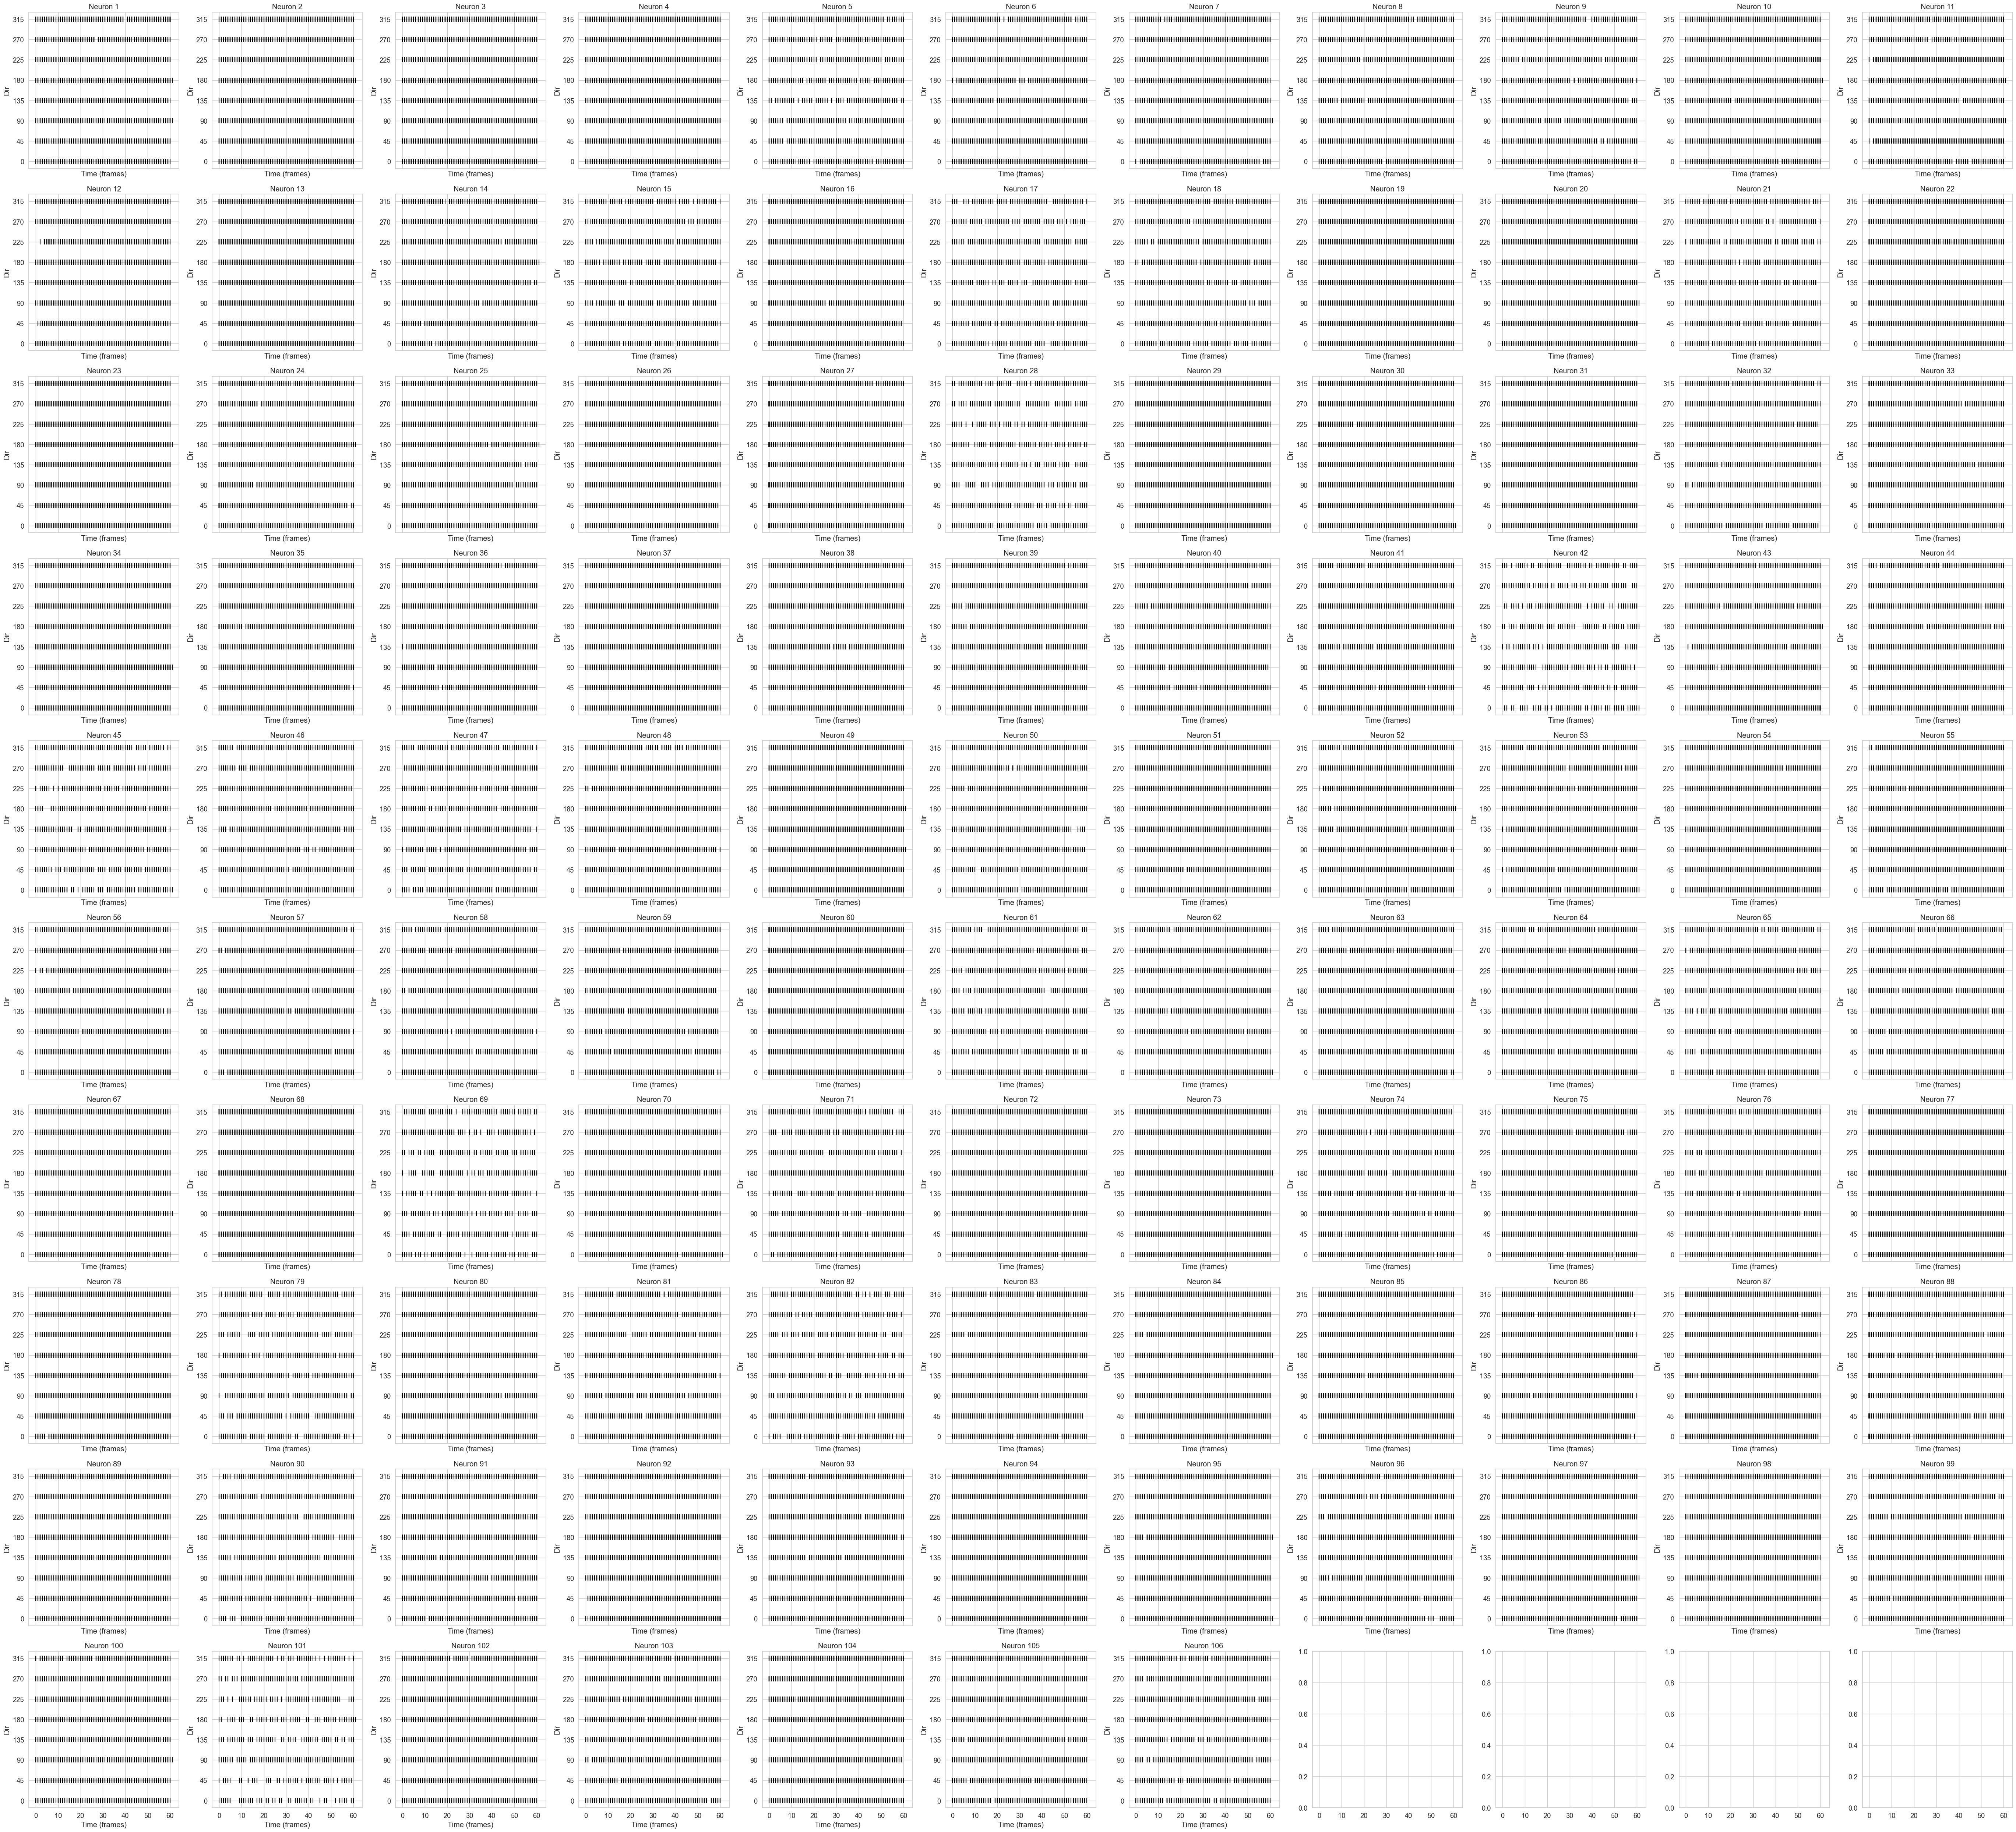

In [33]:
# Plot spike rasters for multiple neurons sorted by direction
def plotRaster(
    spikes: pd.DataFrame, neurons: list, delta, max_y, condition, stimDur=60
):
    """Plot spike rasters for multiple neurons sorted by condition.

    Parameters
    ----------
    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neurons: list
        List of neuron IDs to plot.

    deltaDir: int
        Step size for y-axis ticks.

    stimDur: int
        Duration of the stimulus in frames.

    condition: str
        Condition to sort by, can be 'Dir', 'Frequency', etc.

    Note
    ----
    This function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------

    # create subplots based on the number of neurons
    n_neurons = len(neurons)
    n_cols = int(np.ceil(np.sqrt(n_neurons)))
    n_rows = int(np.ceil(n_neurons / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True
    )

    # flatten axes array and trim excess if needed
    axes = axes.flatten()

    # ensure axes is iterable even for a single neuron
    if n_neurons == 1:
        axes = [axes]

    for ax, neuron in zip(axes, neurons):
        # filter data for the current neuron
        x = spikes.loc[spikes["Neuron"] == neuron, "relTime"]
        y = spikes.loc[spikes["Neuron"] == neuron, condition]

        # create a scatter plot on the provided axis
        ax.scatter(x, y, marker="|", color="black", s=100)
        ax.set_xlabel("Time (frames)")
        ax.set_ylabel(condition)
        ax.set_title(f"Neuron {neuron}")
        ax.set_yticks(np.arange(0, max_y, delta))
        ax.set_xticks(np.arange(0, stimDur + 1, 10))

    plt.tight_layout()
    plt.show()


stimDur = 60  # duration of the stimulus in frames
deltaDir = 45  # direction step in degrees
deltaFreq = 1  # frequency step in Hz
condition = "Dir"  # condition to sort by, can be 'Dir', 'Frequency'
max_y = 360  # maximum y value for the plot


plotRaster(
    spike_df,
    neurons=list(range(1, 107)),
    delta=deltaDir,
    max_y=max_y,
    condition=condition,
)

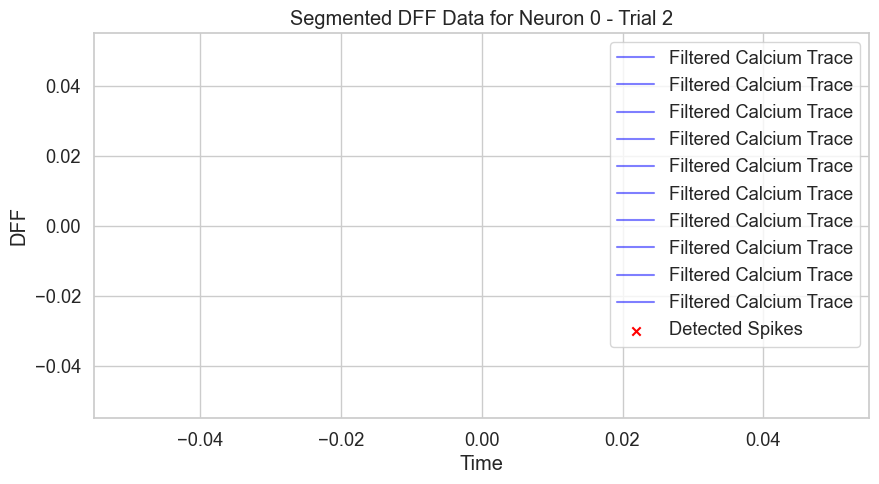

In [39]:
neuron_idx = 0  # index of the neuron to plot
trial_idx = 2  # index of the trial to plot
# plot the segmented data for the first stimulus epoch
stims = data["stim_table"]
start, end = stims.iloc[trial_idx]["start"], stims.iloc[trial_idx]["end"]
filtered_segmented_data = filtered_dff_df[filtered_dff_df["Neuron"] == neuron_idx][
    int(start) : int(end)
]
plt.figure(figsize=(10, 5))
plt.plot(
    filtered_segmented_data, label=f"Filtered Calcium Trace", color="blue", alpha=0.5
)
plt.scatter(
    spike_df[(spike_df["Neuron"] == neuron_idx) & (spike_df["Trial"] == trial_idx)][
        "relTime"
    ],
    spike_df[(spike_df["Neuron"] == neuron_idx) & (spike_df["Trial"] == trial_idx)][
        "FilteredDFF"
    ],
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title(f"Segmented DFF Data for Neuron {neuron_idx} - Trial {trial_idx}")
plt.xlabel("Time")
plt.ylabel("DFF")
plt.legend()
plt.show()

## Tuning functions

In [40]:
# vonMises tuning curve estimation
def vonMises(
    theta: np.ndarray, alpha: float, kappa: float, ny: float, phi: float
) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    theta, phi = np.deg2rad(theta), np.deg2rad(phi)

    return np.exp(
        alpha + kappa * (np.cos(2 * (theta - phi)) - 1) + ny * (np.cos(theta - phi) - 1)
    )

In [ ]:
def tuningCurve(
    counts: np.ndarray, dirs: np.ndarray, neuron, show: bool = True
) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        alpha (α), kappa (κ), ny (ν), phi (ϕ) parameters of the fitted von Mises tuning curve.
        The order of the parameters is [α, κ, ν, ϕ].
    """
    (alpha, kappa, ny, phi), _ = opt.curve_fit(vonMises, dirs, counts, maxfev=100000)

    if show:

        theta = np.linspace(0, 360, 1000)
        fig, ax = plt.subplots(figsize=(8, 4))
        fig.suptitle(f"Von Mises Tuning Curve for Neuron {neuron}", fontsize=16)
        ax.plot(dirs, counts.mean(axis=1), "o", label="Data")
        ax.plot(theta, vonMises(theta, alpha, kappa, ny, phi), label="Fitted Curve")
        ax.set_xlabel("Direction (degrees)")
        ax.set_ylabel("Spike Count")
        ax.set_title(
            f"Alpha: {alpha:.2f}, Kappa: {kappa:.2f}, Ny: {ny:.2f}, Phi: {phi:.2f}"
        )
        ax.set_xlim(0, 360)
        ax.set_ylim(0, counts.max() * 1.2)
        ax.set_xticks(np.arange(0, 361, 45))
        ax.set_xticklabels(np.arange(0, 361, 45))
        ax.set_yticks(np.arange(0, counts.max() * 1.2, 5))
        ax.set_yticklabels(np.arange(0, counts.max() * 1.2, 5))
        ax.grid()
        ax.legend()
        plt.show()
    return np.array([alpha, kappa, ny, phi])

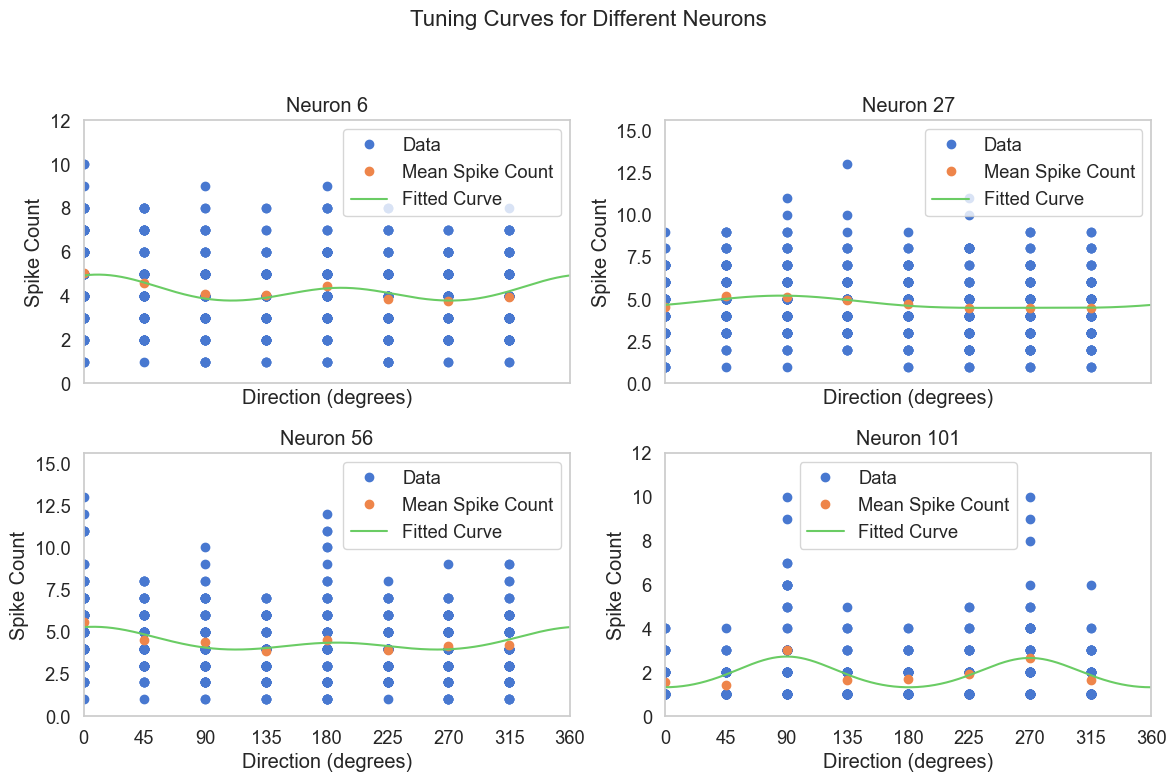

In [53]:
def get_data(neurons_df, neuron):
    # Filter for the given neuron
    spk_by_dir = (
        neurons_df[neurons_df["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])
        .size()  # Count the number of spikes per direction and trial
        .reset_index(name="spike_count")
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["spike_count"].values

    # Ensure zero entries for missing directions
    for direction in np.unique(neurons_df["Dir"]):
        if direction not in dirs:
            dirs = np.append(dirs, direction)
            counts = np.append(counts, 0)

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted


# List of neurons to plot
neurons = [6, 27, 56, 101]  # Example neuron indices, adjust as needed

fig, axes = plt.subplots(len(neurons) // 2, 2, figsize=(12, 8), sharex=True)
fig.suptitle("Tuning Curves for Different Neurons", fontsize=16)
axes = axes.flatten()

for i, neuron in enumerate(neurons):
    ax = axes[i]
    dirs, counts = get_data(spike_df, neuron)

    unique_dirs = np.sort(np.unique(dirs))
    df = pd.DataFrame({"Counts": counts, "Direction": dirs}).groupby("Direction").mean()

    α0 = np.log(np.max(df.values.flatten()) + 1e-3)
    ϕ0 = unique_dirs[np.argmax(df.values.flatten())]
    p0 = [α0, 1.0, 1.0, ϕ0]

    try:
        p, _ = opt.curve_fit(
            vonMises, df.index.values, df.values.flatten(), p0=p0, maxfev=10000
        )
    except RuntimeError:
        p = p0  # fallback to initial guess if fitting fails

    ax.plot(dirs, counts, "o", label="Data")
    ax.plot(df.index.values, df.values.flatten(), "o", label="Mean Spike Count")
    theta = np.linspace(0, 360, 1000)
    ax.plot(theta, vonMises(theta, *p), label="Fitted Curve")
    ax.set_title(f"Neuron {neuron}")
    ax.set_xlabel("Direction (degrees)")
    ax.set_ylabel("Spike Count")
    ax.set_xlim(0, 360)
    ax.set_ylim(0, counts.max() * 1.2)
    ax.set_xticks(np.arange(0, 361, 45))
    ax.grid()
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 4 Statistical Testing
## 4.1 Permutation Test

In [ ]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """

    # calculate vector of average spike counts for each unique direction
    unique_dirs = np.sort(np.unique(dirs))
    m = np.array([np.mean(counts[dirs == d]) for d in unique_dirs])

    # define complex exponential vector with fourier component [1, 2]
    v = np.exp(1j * psi * np.deg2rad(unique_dirs))

    # compute observed projection
    q = np.dot(m, v)
    q_mag = np.abs(q)

    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)
    qdistr = np.zeros(niters)
    for i in range(niters):
        # shuffle the counts across trials
        shuffled_counts = rng.permutation(counts)
        # recompute average spike counts for each direction using shuffled data
        m_perm = np.array([np.mean(shuffled_counts[dirs == d]) for d in unique_dirs])
        # compute projection for shuffled data
        q_perm = np.dot(m_perm, v)
        qdistr[i] = np.abs(q_perm)

    # calculate the p-value as the fraction of permuted |q| more extreme than observed
    p = np.mean(qdistr > q_mag)

    # if show is true, plot the null distribution and the observed value
    if show:
        plt.figure(figsize=(8, 5))
        plt.hist(qdistr, bins=30, alpha=0.7, label="null distribution")
        plt.axvline(q_mag, color="red", linestyle="--", label="observed |q|")
        plt.xlabel("|q|")
        plt.ylabel("frequency")
        plt.title(f"Permutation test (psi = {psi})\np-value = {p:.4f}")
        plt.legend()
        plt.show()
        
    return p, q_mag, qdistr

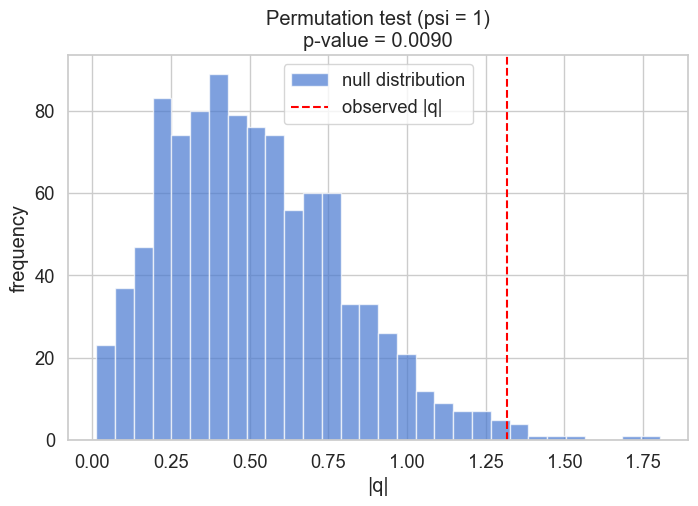

Neuron 6: p-value = 0.0090, |q| = 1.3174


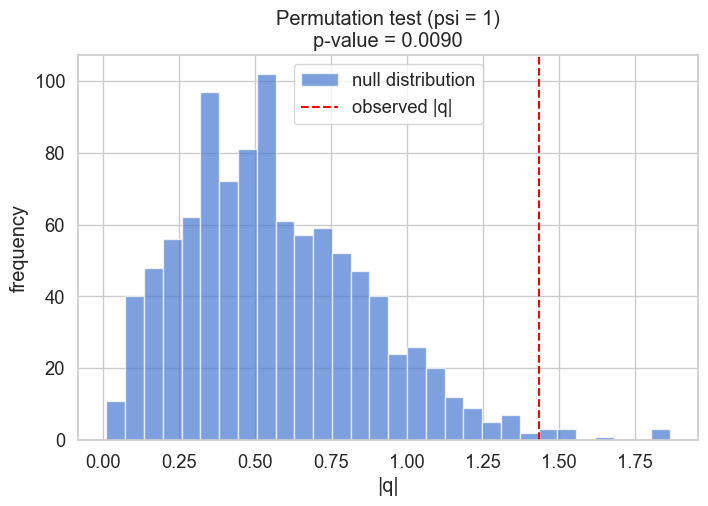

Neuron 27: p-value = 0.0090, |q| = 1.4347


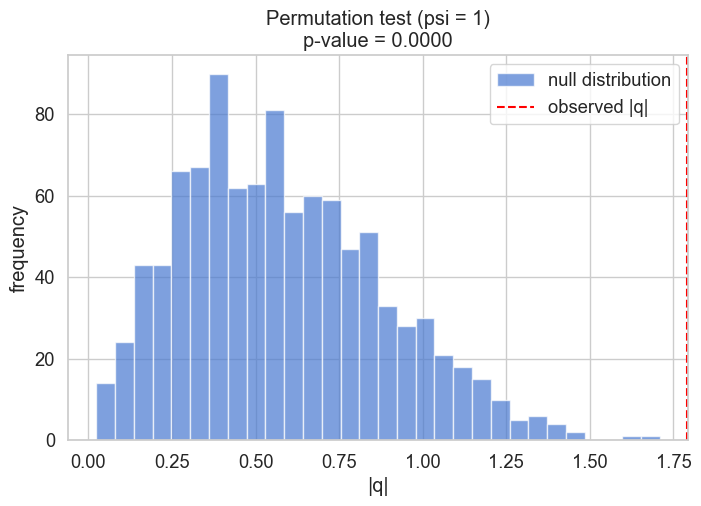

Neuron 56: p-value = 0.0000, |q| = 1.7916


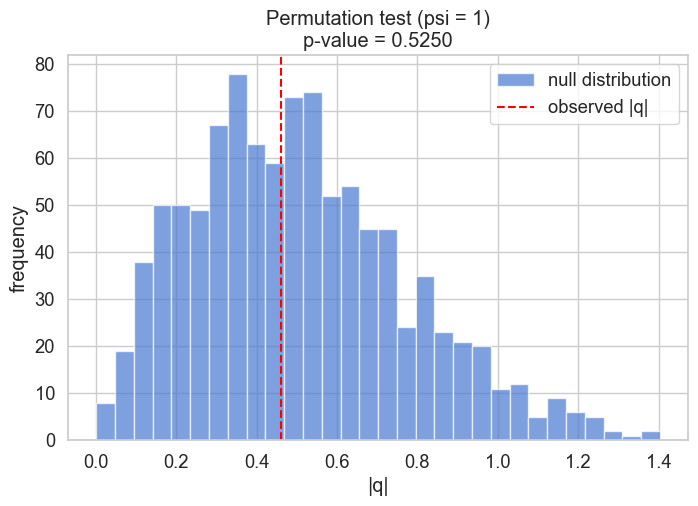

Neuron 101: p-value = 0.5250, |q| = 0.4607


In [52]:
neurons = [6, 27, 56, 101]  # Example neuron indices, adjust as needed
for neuron in neurons:
    dirs, counts = get_data(spike_df, neuron)
    p, q, qdistr = testTuning(counts, dirs, show=True)
    print(f"Neuron {neuron}: p-value = {p:.4f}, |q| = {q:.4f}")

In [48]:
# --------------------------------------------------
# Test all cells for orientation / direction tuning.
# Which ones are selective? (0.5 pts)
# --------------------------------------------------

# get unique neurons
neurons = spike_df["Neuron"].unique()
# create a DataFrame to store the results
results = pd.DataFrame(
    columns=[
        "Neuron",
        "p-value (direction)",
        "p-value (orientation)",
        "|q| (direction)",
        "|q| (orientation)",
    ]
)
# create lists to store results
p_values_dir = []
p_values_ori = []
q_values_dir = []
q_values_ori = []
# loop through all neurons and test for direction tuning
for neuron in neurons:
    dirs, counts = get_data(spike_df, neuron)
    p_dir, q_dir, _ = testTuning(counts, dirs, psi=1, show=False)
    p_ori, q_ori, _ = testTuning(counts, dirs, psi=2, show=False)
    # append results to lists
    p_values_dir.append(p_dir)
    p_values_ori.append(p_ori)
    q_values_dir.append(q_dir)
    q_values_ori.append(q_ori)

# make dataframe
results = pd.DataFrame(
    {
        "Neuron": neurons,
        "p-value (direction)": p_values_dir,
        "p-value (orientation)": p_values_ori,
        "|q| (direction)": q_values_dir,
        "|q| (orientation)": q_values_ori,
    }
)

# add a column for significance
results["Significant (direction)"] = results["p-value (direction)"] < 0.01
results["Significant (orientation)"] = results["p-value (orientation)"] < 0.01

In [49]:
print(
    "The following neurons are selective for direction: ",
    results.loc[results["Significant (direction)"], "Neuron"].values,
)
print(
    "Number of neurons selective for direction: ",
    results.loc[results["Significant (direction)"], "Neuron"].count(),
)

The following neurons are selective for direction:  [ 6 27 56]
Number of neurons selective for direction:  3


In [50]:
print(
    "The following neurons are selective for orientation: ",
    results.loc[results["Significant (orientation)"], "Neuron"].values,
)
print(
    "Number of neurons selective for orientation: ",
    results.loc[results["Significant (orientation)"], "Neuron"].count(),
)

The following neurons are selective for orientation:  [  6  11  12  20  30  34  43  47  52  55  56  62  71  78  79  85  92  98
 101]
Number of neurons selective for orientation:  19
